In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['precio']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'model': regr,
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target),
        'standarized_residuals': standarized_residuals,
        'fitted': fitted
    }

# Distrito Federal de Mexico

In [2]:
df = pd.read_csv('./mexico_district.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12733 entries, 0 to 12732
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  12733 non-null  int64  
 1   Unnamed: 0.1                12733 non-null  int64  
 2   Unnamed: 0.1.1              12733 non-null  int64  
 3   Unnamed: 0.1.1.1            12733 non-null  int64  
 4   Unnamed: 0.1.1.1.1          12733 non-null  int64  
 5   Unnamed: 0.1.1.1.1.1        12733 non-null  int64  
 6   id                          12733 non-null  int64  
 7   tipodepropiedad             12733 non-null  object 
 8   ciudad                      12733 non-null  object 
 9   provincia                   12733 non-null  object 
 10  antiguedad                  12733 non-null  float64
 11  habitaciones                12733 non-null  float64
 12  garages                     12733 non-null  float64
 13  banos                       127

In [4]:
df.groupby('tipodepropiedad').count()['ciudad']

tipodepropiedad
Apartamento    7799
Casa           4934
Name: ciudad, dtype: int64

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


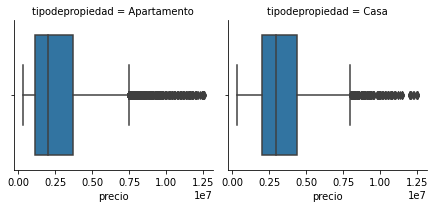

In [5]:
g = sns.FacetGrid(df, col="tipodepropiedad", col_wrap=5)
g.map(sns.boxplot, "precio")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12733 entries, 0 to 12732
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  12733 non-null  int64  
 1   Unnamed: 0.1                12733 non-null  int64  
 2   Unnamed: 0.1.1              12733 non-null  int64  
 3   Unnamed: 0.1.1.1            12733 non-null  int64  
 4   Unnamed: 0.1.1.1.1          12733 non-null  int64  
 5   Unnamed: 0.1.1.1.1.1        12733 non-null  int64  
 6   id                          12733 non-null  int64  
 7   tipodepropiedad             12733 non-null  object 
 8   ciudad                      12733 non-null  object 
 9   provincia                   12733 non-null  object 
 10  antiguedad                  12733 non-null  float64
 11  habitaciones                12733 non-null  float64
 12  garages                     12733 non-null  float64
 13  banos                       127

In [7]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['year'] = df['fecha'].apply(lambda x: x.year)
df['year'].value_counts()

2016    5993
2015    2722
2014    1896
2013    1654
2012     468
Name: year, dtype: int64

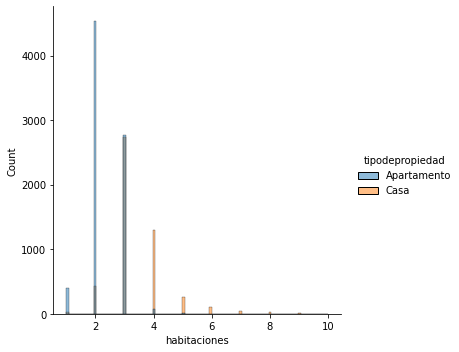

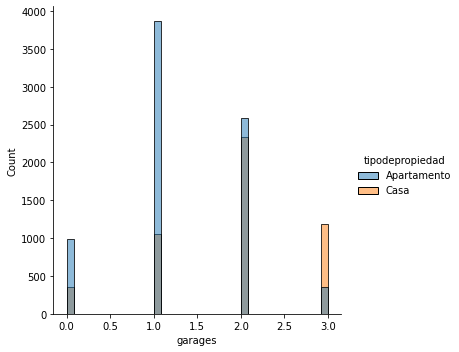

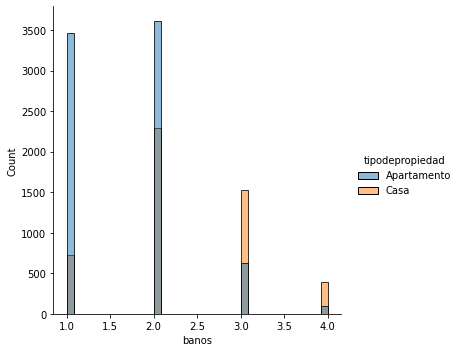

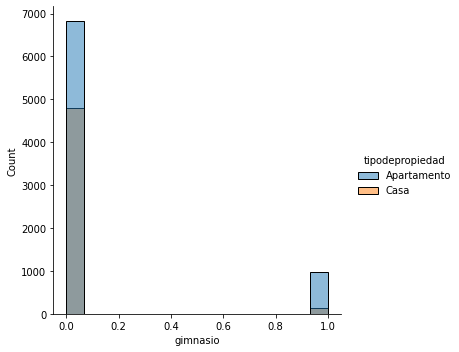

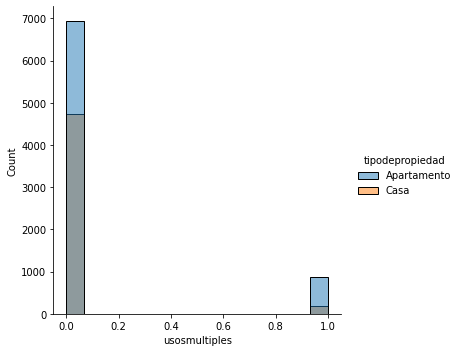

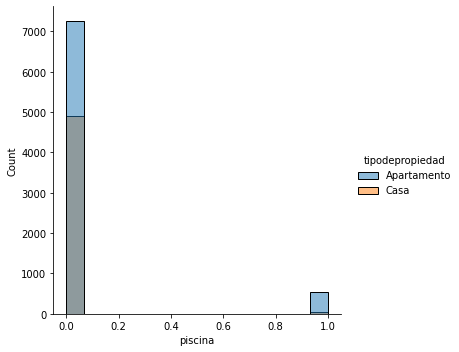

In [8]:
for f in ['habitaciones', 'garages', 'banos', 'gimnasio', 'usosmultiples', 'piscina']:
    sns.displot(df, x=f, hue="tipodepropiedad")

In [9]:
amenities = df.groupby('tipodepropiedad').agg({'piscina':'sum', 'gimnasio':'sum', 'usosmultiples':'sum', 'ciudad':'count'})
amenities['prob_piscina'] = amenities['piscina']/amenities['ciudad']
amenities['prob_gimnasio'] = amenities['gimnasio']/amenities['ciudad']
amenities['prob_usosmultiples'] = amenities['usosmultiples']/amenities['ciudad']
amenities

piscina  gimnasio  usosmultiples  ciudad  prob_piscina  \
tipodepropiedad                                                           
Apartamento        540.0     973.0          864.0    7799      0.069240   
Casa                33.0     127.0          192.0    4934      0.006688   

                 prob_gimnasio  prob_usosmultiples  
tipodepropiedad                                     
Apartamento            0.12476            0.110783  
Casa                   0.02574            0.038914

# Metros

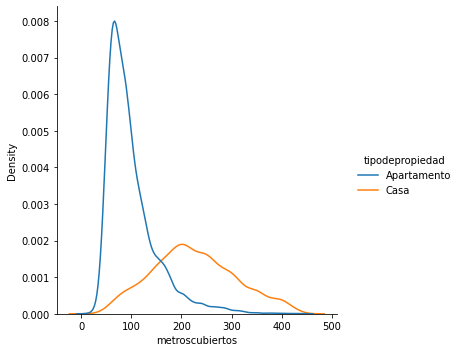

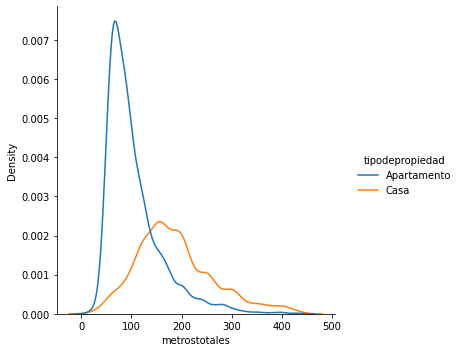

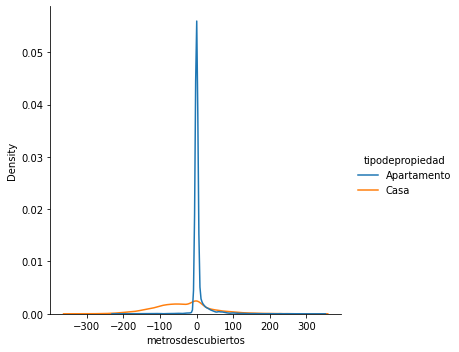

In [10]:
df['metrosdescubiertos']=df['metrostotales']-df['metroscubiertos']
for f in ['metroscubiertos', 'metrostotales','metrosdescubiertos']:
    sns.displot(df, x=f, hue="tipodepropiedad", kind='kde')

Los departamentos tienen menos metros cubiertos como totales y no tienen descubiertos
En las casas esto no tiene sentido. Dos alternativas: error de carga, o estan considerando metros totales como los del terreno y cubiertos por plantas

In [11]:
df.corr()['precio']

Unnamed: 0                    0.006197
Unnamed: 0.1                  0.006197
Unnamed: 0.1.1                0.006197
Unnamed: 0.1.1.1              0.006197
Unnamed: 0.1.1.1.1            0.006197
Unnamed: 0.1.1.1.1.1          0.006197
id                           -0.001112
antiguedad                   -0.007983
habitaciones                  0.211056
garages                       0.491067
banos                         0.520497
metroscubiertos               0.550793
metrostotales                 0.563091
idzona                        0.079617
lat                          -0.029301
lng                           0.002954
gimnasio                      0.234863
usosmultiples                 0.160892
piscina                       0.230434
escuelascercanas              0.059435
centroscomercialescercanos    0.088364
precio                        1.000000
metrosdescubiertos           -0.108361
year                          0.093188
Name: precio, dtype: float64

## Tamaño y ambientes 'utilitarios'

In [12]:
df[['garages', 'banos', 'habitaciones', 'metroscubiertos']].corr()

garages     banos  habitaciones  metroscubiertos
garages          1.000000  0.534089      0.338619         0.526719
banos            0.534089  1.000000      0.520187         0.644485
habitaciones     0.338619  0.520187      1.000000         0.614220
metroscubiertos  0.526719  0.644485      0.614220         1.000000

## Ambientes de lujo

In [13]:
df[['usosmultiples','piscina', 'gimnasio']].corr()

usosmultiples   piscina  gimnasio
usosmultiples       1.000000  0.427876  0.513693
piscina             0.427876  1.000000  0.608837
gimnasio            0.513693  0.608837  1.000000

Los ambientes de lujo no tienen tanta correlación con los utilitarios

In [14]:
df[['garages', 'banos', 'habitaciones', 'metroscubiertos', 'usosmultiples','piscina', 'gimnasio']].corr()

garages     banos  habitaciones  metroscubiertos  \
garages          1.000000  0.534089      0.338619         0.526719   
banos            0.534089  1.000000      0.520187         0.644485   
habitaciones     0.338619  0.520187      1.000000         0.614220   
metroscubiertos  0.526719  0.644485      0.614220         1.000000   
usosmultiples    0.109518  0.083517     -0.086800        -0.020928   
piscina          0.111029  0.069152     -0.090766        -0.017010   
gimnasio         0.124186  0.078403     -0.115110        -0.035483   

                 usosmultiples   piscina  gimnasio  
garages               0.109518  0.111029  0.124186  
banos                 0.083517  0.069152  0.078403  
habitaciones         -0.086800 -0.090766 -0.115110  
metroscubiertos      -0.020928 -0.017010 -0.035483  
usosmultiples         1.000000  0.427876  0.513693  
piscina               0.427876  1.000000  0.608837  
gimnasio              0.513693  0.608837  1.000000

# Habitaciones

In [15]:
df.habitaciones.unique()

array([ 2.,  3.,  1.,  4.,  8.,  6., 10.,  5.,  7.,  9.])

Tenemos dos maneras de pensar este feature, ya sea como una variable entera o como categorias (por ejemplo, 2 ambientes no es el doble que monoambiente).
Seguramente además, entre 8 y 10 ambientes la diferencia de precio no sea tan grande como entre 1 y 2 por el impacto que tiene).
df.ambientes

(array([4.370e+02, 4.958e+03, 5.510e+03, 1.379e+03, 2.700e+02, 1.110e+02,
        3.700e+01, 2.200e+01, 5.000e+00, 4.000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

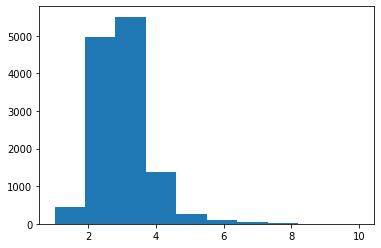

In [16]:
plt.hist(df.habitaciones)

<AxesSubplot:xlabel='habitaciones', ylabel='precio'>

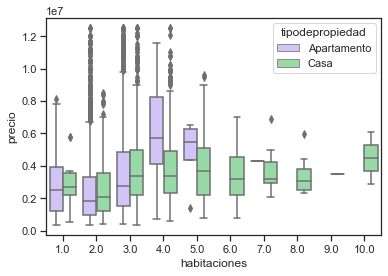

In [17]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="habitaciones", y="precio",
            hue="tipodepropiedad", palette=["m", "g"],
            data=df[df.year == 2016])

Fijo un año porque me interesa ver una foto del mercado, y que su evolución temporal no interfiera en esa visión.

- Entre 1 y dos ambientes, tal vez los monoambientes son mas buscados por ser pocos, y eso infla un poco el precio. Por otro lado, es lógico que la relación no sea muy lineal porque tanto 1 como 2 require los servicios básicos costos de cañerias, cableados etc.
- Dos ambientes tiene outliers
- Departamentos de 4 y 5 ambientes seguramente son un segmento mas de lujo, tal vez con amenities, evidentemente son mas caros que las casas en ese segmento.
- 6-10 ambientes son todas casas y estan bastante parejas en ese sentido.

Idea de modelado: 5 categorias

- 1
- 2
- 3 
- 4,5
- 6 o mas

In [18]:
df[df.tipodepropiedad == 'Apartamento'].corr()['precio']

Unnamed: 0                    0.001673
Unnamed: 0.1                  0.001673
Unnamed: 0.1.1                0.001673
Unnamed: 0.1.1.1              0.001673
Unnamed: 0.1.1.1.1            0.001673
Unnamed: 0.1.1.1.1.1          0.001673
id                           -0.005892
antiguedad                   -0.205125
habitaciones                  0.229910
garages                       0.581725
banos                         0.630106
metroscubiertos               0.759922
metrostotales                 0.737899
idzona                        0.085180
lat                          -0.032947
lng                           0.012778
gimnasio                      0.337169
usosmultiples                 0.222013
piscina                       0.325142
escuelascercanas              0.085640
centroscomercialescercanos    0.130325
precio                        1.000000
metrosdescubiertos            0.116182
year                          0.157857
Name: precio, dtype: float64

In [19]:
df[df.tipodepropiedad == 'Casa'].corr()['precio']

Unnamed: 0                    0.007530
Unnamed: 0.1                  0.007530
Unnamed: 0.1.1                0.007530
Unnamed: 0.1.1.1              0.007530
Unnamed: 0.1.1.1.1            0.007530
Unnamed: 0.1.1.1.1.1          0.007530
id                            0.005028
antiguedad                    0.091043
habitaciones                  0.077086
garages                       0.311764
banos                         0.340301
metroscubiertos               0.521435
metrostotales                 0.399572
idzona                        0.159977
lat                          -0.003898
lng                          -0.149799
gimnasio                      0.069039
usosmultiples                 0.090680
piscina                       0.033506
escuelascercanas              0.033895
centroscomercialescercanos    0.068208
precio                        1.000000
metrosdescubiertos           -0.155639
year                          0.141109
Name: precio, dtype: float64

In [20]:
df.ciudad.nunique()

17

In [21]:
df.to_csv('./mexico_district.csv')

Ver kepler
Distrito de Mexico Bounding Box

In [22]:
df = df[(df.lat<19.603716) & (df.lat>19.193392) & (df.lng>-99.373595) & (df.lng< -98.930977)]
df.to_csv('./mexico_district_bounded.csv')

# Analizando por areas

In [23]:
df.ciudad.nunique()

17

In [24]:
por_zona = df.groupby('ciudad').count()[['tipodepropiedad']].rename(columns={'tipodepropiedad':'propiedades'})
por_zona

propiedades
ciudad                             
Alvaro Obregón                 1255
Azcapotzalco                    476
Benito Juárez                  2429
Coyoacán                       1425
Cuajimalpa de Morelos           397
Cuauhtémoc                     1360
Gustavo A. Madero               830
Iztacalco                       322
Iztapalapa                      856
La Magdalena Contreras          272
Miguel Hidalgo                 1127
Milpa Alta                        4
Tlalpan                        1122
Tláhuac                         110
Venustiano Carranza             397
Xochimilco                      315
otra                              1

In [25]:
df = df[~df.ciudad.isin(['otra', 'Milpa Alta'])]

(array([1., 1., 3., 1., 1., 2., 2., 1., 2., 1.]),
 array([ 929439.80909091, 1290373.58057477, 1651307.35205862,
        2012241.12354248, 2373174.89502633, 2734108.66651019,
        3095042.43799405, 3455976.2094779 , 3816909.98096176,
        4177843.75244561, 4538777.52392947]),
 <BarContainer object of 10 artists>)

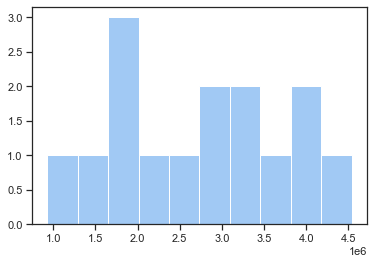

In [26]:
plt.hist(df.groupby('ciudad').mean()[['precio']])

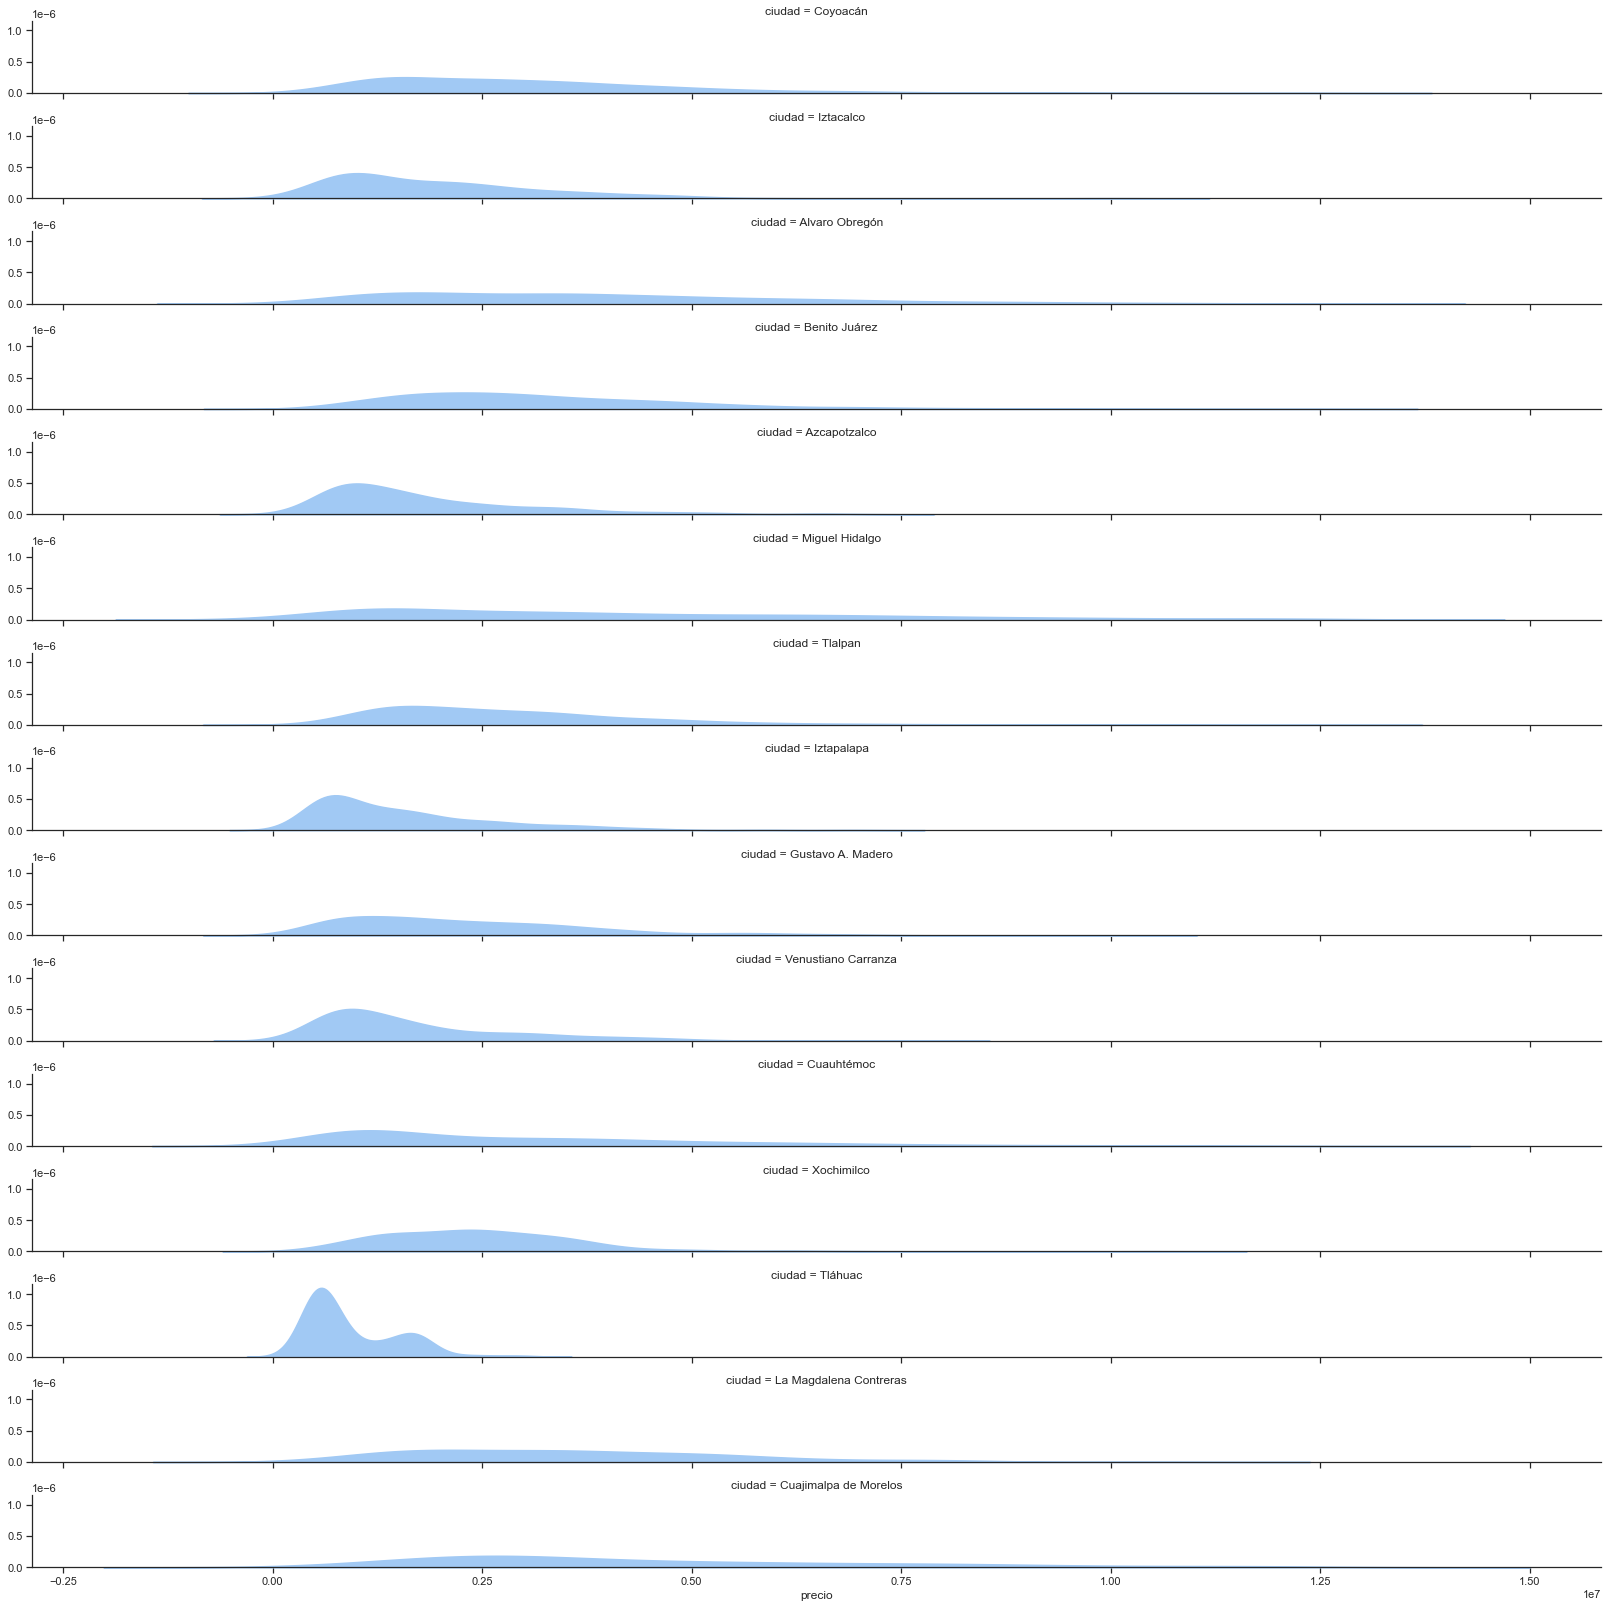

In [27]:
a = sns.FacetGrid(df, row="ciudad",  aspect=15, height=1.5)
a.map(sns.kdeplot,
      "precio",
      clip_on=False,
      fill=True,
      alpha=1,
      linewidth=1.5
     )

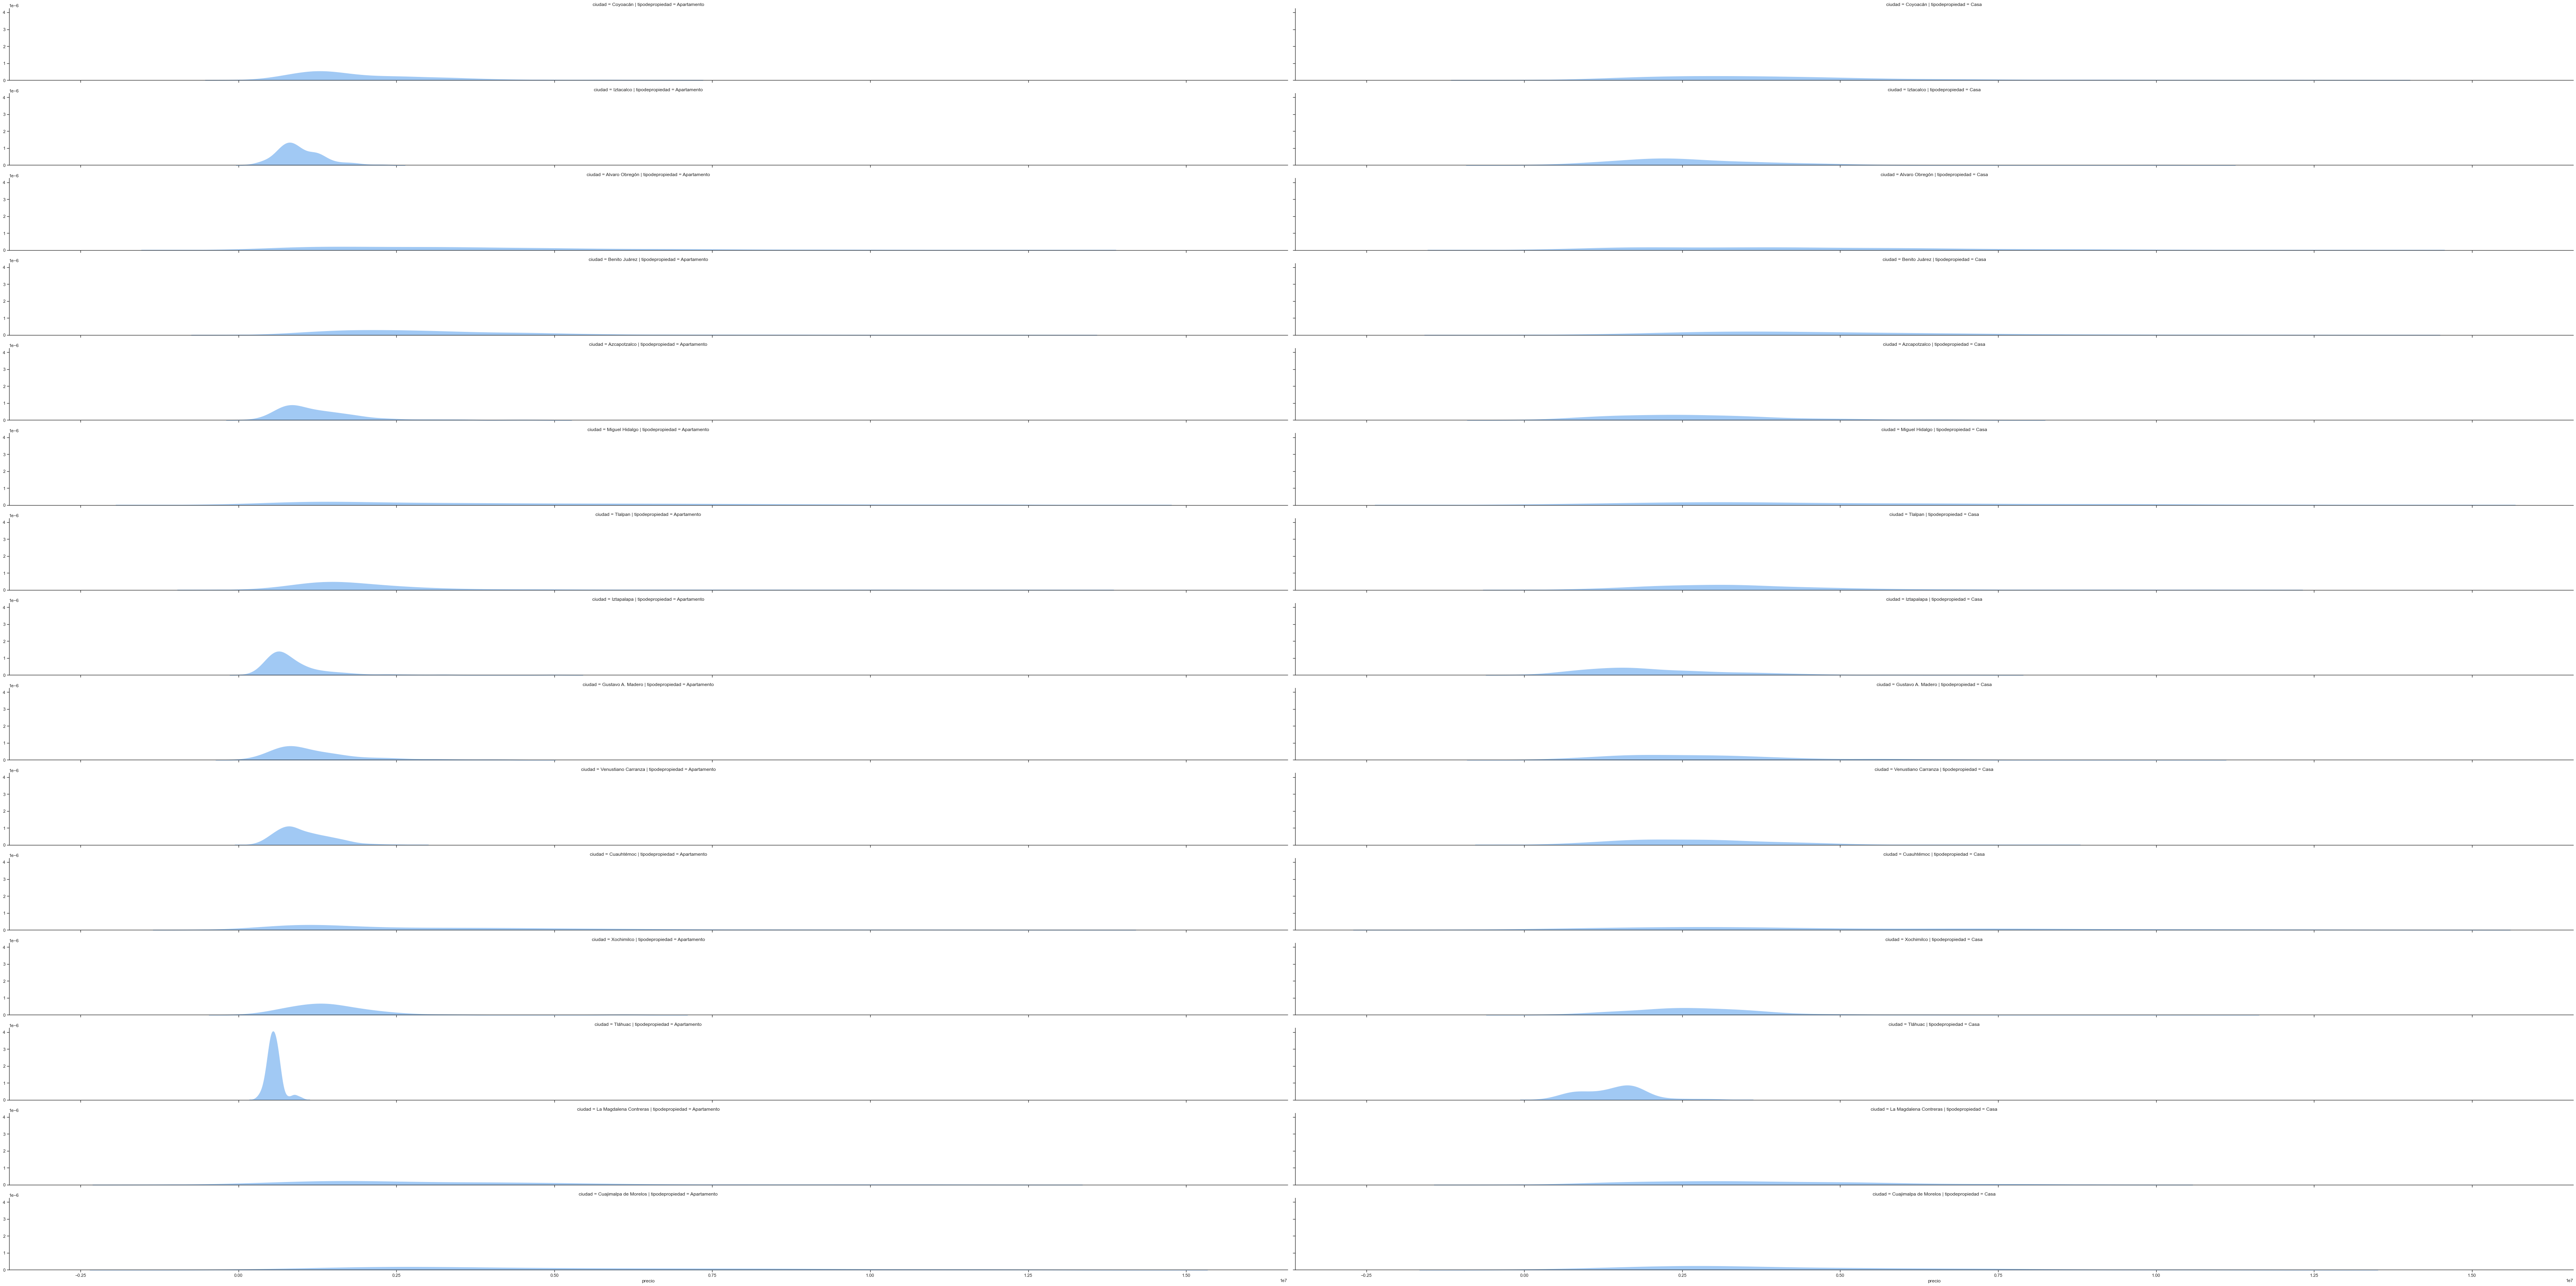

In [28]:


a = sns.FacetGrid(df, row="ciudad", col='tipodepropiedad', aspect=15)
a.map(sns.kdeplot,
      "precio",
      clip_on=False,
      fill=True,
      alpha=1,
      linewidth=1.5
     )

Calculemos metro cuadrado por area

In [29]:
metro_por_zona = df.groupby(['ciudad', 'tipodepropiedad']).agg({'precio':'sum', 'metroscubiertos':'sum'})
metro_por_zona['precio_metro'] = np.round(metro_por_zona['precio'] / metro_por_zona['metroscubiertos'])

In [30]:
metro_por_zona.sort_values('precio_metro', ascending=False)

precio  metroscubiertos  \
ciudad                 tipodepropiedad                                  
Miguel Hidalgo         Apartamento      4.044371e+09         117039.0   
Cuajimalpa de Morelos  Apartamento      1.371372e+09          42432.0   
Alvaro Obregón         Apartamento      2.564692e+09          84052.0   
Cuauhtémoc             Apartamento      3.293490e+09         108608.0   
Benito Juárez          Apartamento      6.257820e+09         217497.0   
La Magdalena Contreras Apartamento      1.834728e+08           7445.0   
Tlalpan                Apartamento      1.106397e+09          50765.0   
Coyoacán               Apartamento      1.079446e+09          51303.0   
Miguel Hidalgo         Casa             6.091582e+08          29941.0   
Cuauhtémoc             Casa             9.759790e+08          48004.0   
Benito Juárez          Casa             1.662126e+09          87069.0   
Azcapotzalco           Apartamento      3.609140e+08          20538.0   
Alvaro Obregón         Casa             2.291763e+09         132185.0   
Xochimilco             Apartamento      1.021030e+08           5988.0   
Coyoacán               Casa             3.288449e+09         196245.0   
Gustavo A. Madero      Apartamento      3.135707e+08          19020.0   
Cuajimalpa de Morelos  Casa             4.305223e+08          26396.0   
Venustiano Carranza    Apartamento      2.442427e+08          15826.0   
La Magdalena Contreras Casa             7.931130e+08          52735.0   
Tlalpan                Casa             2.130887e+09         143811.0   
Iztacalco              Apartamento      1.277955e+08           8822.0   
Iztapalapa             Apartamento      3.122359e+08          23547.0   
Gustavo A. Madero      Casa             1.636245e+09         124589.0   
Xochimilco             Casa             6.736119e+08          51503.0   
Azcapotzalco           Casa             4.968721e+08          39308.0   
Iztacalco              Casa             4.993484e+08          39552.0   
Venustiano Carranza    Casa             4.329000e+08          35814.0   
Iztapalapa             Casa             1.018551e+09          91220.0   
Tláhuac                Apartamento      3.561048e+07           3334.0   
                       Casa             6.662790e+07           7637.0   

                                        precio_metro  
ciudad                 tipodepropiedad                
Miguel Hidalgo         Apartamento           34556.0  
Cuajimalpa de Morelos  Apartamento           32319.0  
Alvaro Obregón         Apartamento           30513.0  
Cuauhtémoc             Apartamento           30325.0  
Benito Juárez          Apartamento           28772.0  
La Magdalena Contreras Apartamento           24644.0  
Tlalpan                Apartamento           21794.0  
Coyoacán               Apartamento           21041.0  
Miguel Hidalgo         Casa                  20345.0  
Cuauhtémoc             Casa                  20331.0  
Benito Juárez          Casa                  19090.0  
Azcapotzalco           Apartamento           17573.0  
Alvaro Obregón         Casa                  17338.0  
Xochimilco             Apartamento           17051.0  
Coyoacán               Casa                  16757.0  
Gustavo A. Madero      Apartamento           16486.0  
Cuajimalpa de Morelos  Casa                  16310.0  
Venustiano Carranza    Apartamento           15433.0  
La Magdalena Contreras Casa                  15040.0  
Tlalpan                Casa                  14817.0  
Iztacalco              Apartamento           14486.0  
Iztapalapa             Apartamento           13260.0  
Gustavo A. Madero      Casa                  13133.0  
Xochimilco             Casa                  13079.0  
Azcapotzalco           Casa                  12640.0  
Iztacalco              Casa                  12625.0  
Venustiano Carranza    Casa                  12087.0  
Iztapalapa             Casa                  11166.0  
Tláhuac                Apartamento           10681.0  
    

<AxesSubplot:title={'center':'Evolución del precio del metro cuadrado por Ciudad, para Apartamentos'}, xlabel='year'>

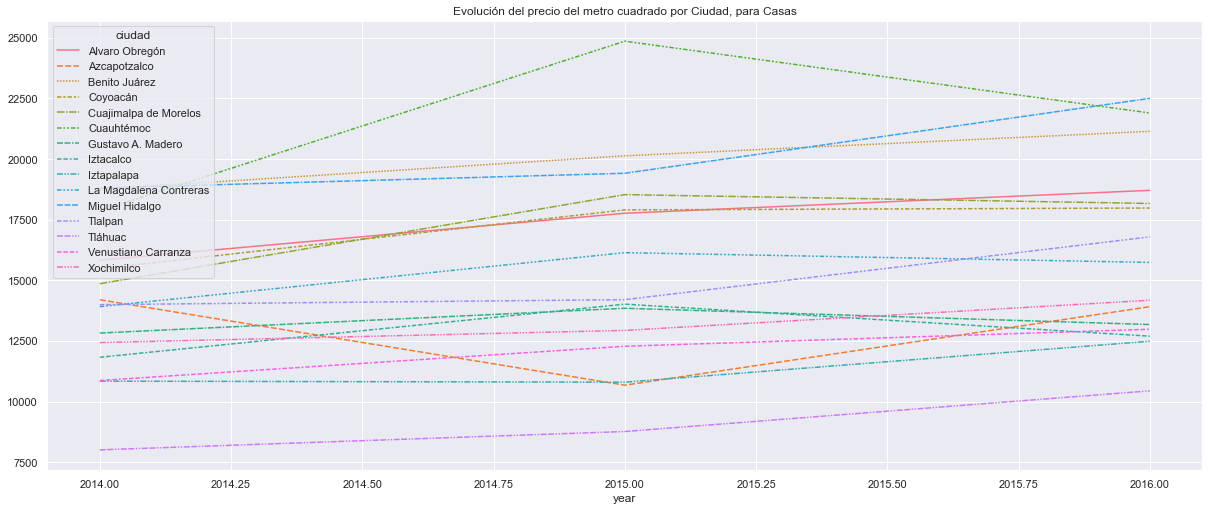

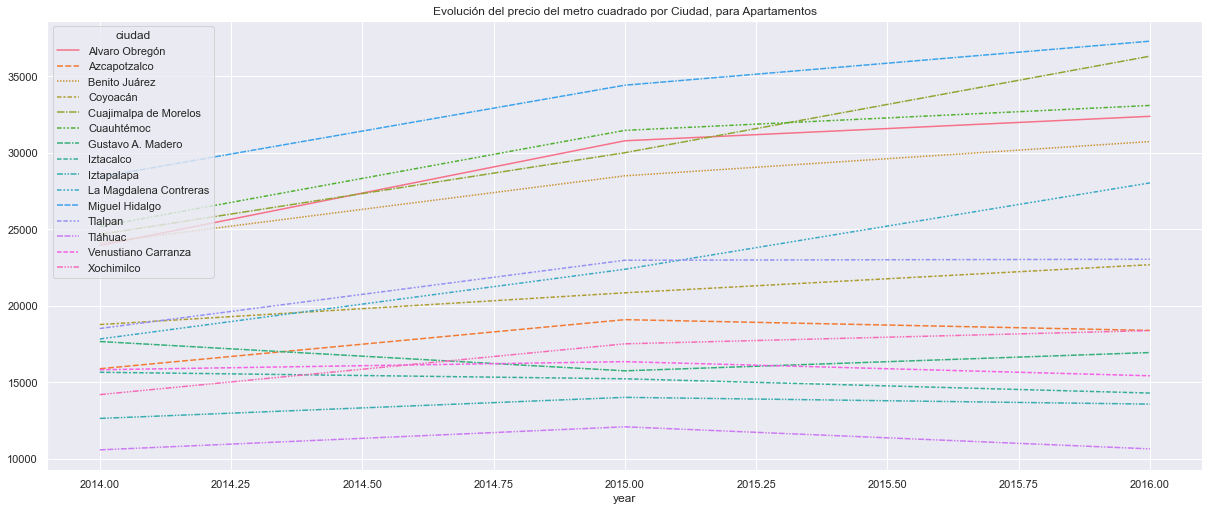

In [31]:
evolucion_metro_por_zona = df.groupby(['year','ciudad', 'tipodepropiedad'], as_index=False).agg({'precio':'sum', 'metroscubiertos':'sum'})
evolucion_metro_por_zona['precio_metro'] = np.round(evolucion_metro_por_zona['precio'] / evolucion_metro_por_zona['metroscubiertos'])
evolucion_casas= evolucion_metro_por_zona[(evolucion_metro_por_zona.tipodepropiedad=='Casa') & (evolucion_metro_por_zona.year.isin(['2014','2015','2016']))]
evolucion_casas = evolucion_casas.pivot("year", "ciudad", "precio_metro")
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.lineplot(data=evolucion_casas)
plt.title("Evolución del precio del metro cuadrado por Ciudad, para Casas")
plt.figure()
evolucion_casas= evolucion_metro_por_zona[(evolucion_metro_por_zona.tipodepropiedad=='Apartamento') & (evolucion_metro_por_zona.year.isin(['2014','2015','2016']))]
evolucion_casas = evolucion_casas.pivot("year", "ciudad", "precio_metro")
plt.title("Evolución del precio del metro cuadrado por Ciudad, para Apartamentos")
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.lineplot(data=evolucion_casas)

Text(0.5, 0, 'Metros totales')

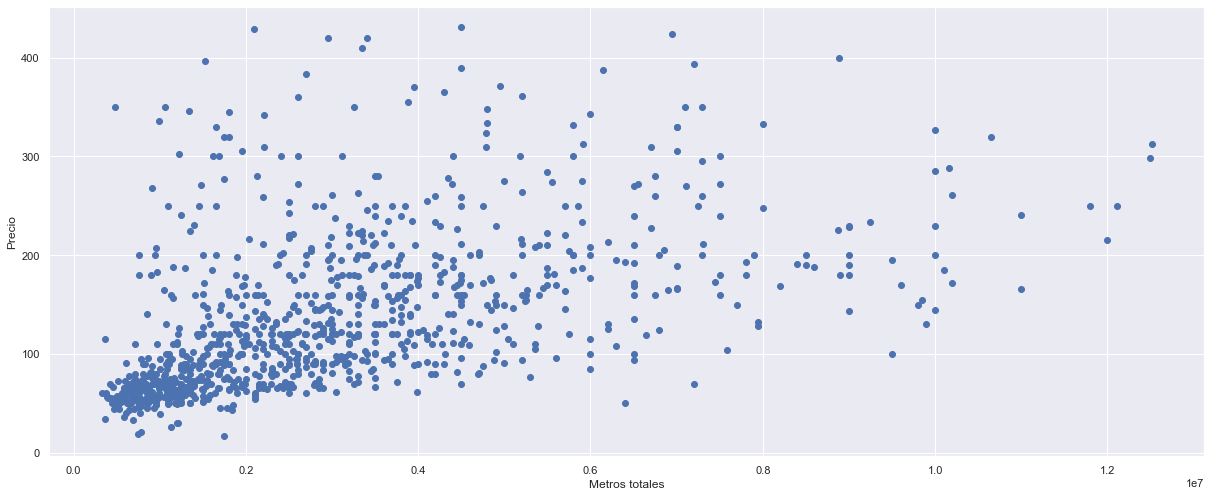

In [32]:
reduced = df.sample(1000)
plt.scatter(reduced['precio'],reduced['metrostotales'])
plt.ylabel('Precio')
plt.xlabel('Metros totales')

# Escuelas y centros comerciales

In [33]:
df.centroscomercialescercanos.unique()

array([1., 0.])

In [34]:
df.escuelascercanas.unique()

array([0., 1.])

In [35]:
df.groupby(['ciudad','centroscomercialescercanos','escuelascercanas',]).count()['id']

ciudad                  centroscomercialescercanos  escuelascercanas
Alvaro Obregón          0.0                         0.0                  426
                                                    1.0                   75
                        1.0                         0.0                   59
                                                    1.0                  695
Azcapotzalco            0.0                         0.0                  165
                                                    1.0                   37
                        1.0                         0.0                   17
                                                    1.0                  257
Benito Juárez           0.0                         0.0                  727
                                                    1.0                   73
                        1.0                         0.0                  132
                                                    1.0                 1497
Coyoacá

# Analisis de regresión

In [36]:
original = df.copy()

In [37]:
df=original

In [38]:
df['tipodepropiedad_encoded'] = df['tipodepropiedad'].apply(lambda x: 0 if x=='Apartamento' else 1)

In [39]:
df.corr()['precio']

Unnamed: 0                    0.005706
Unnamed: 0.1                  0.005706
Unnamed: 0.1.1                0.005706
Unnamed: 0.1.1.1              0.005706
Unnamed: 0.1.1.1.1            0.005706
Unnamed: 0.1.1.1.1.1          0.005706
id                           -0.001055
antiguedad                   -0.007959
habitaciones                  0.211675
garages                       0.491345
banos                         0.520691
metroscubiertos               0.551061
metrostotales                 0.565014
idzona                        0.080014
lat                          -0.031727
lng                          -0.345337
gimnasio                      0.233991
usosmultiples                 0.159781
piscina                       0.230254
escuelascercanas              0.059651
centroscomercialescercanos    0.088172
precio                        1.000000
metrosdescubiertos           -0.107255
year                          0.092435
tipodepropiedad_encoded       0.158820
Name: precio, dtype: floa

In [40]:
features_a_normalizar = ['metrostotales','precio']
for feature in features_a_normalizar:
    df[f'normalizado_{feature}'] = (df[feature]-np.mean(df[feature]))/np.std(df[feature])

In [41]:
df[['metrostotales', 'normalizado_metrostotales']]

metrostotales  normalizado_metrostotales
0               90.0                  -0.607848
1              110.0                  -0.344696
2               47.0                  -1.173625
3              100.0                  -0.476272
4              122.0                  -0.186805
...              ...                        ...
12728          152.0                   0.207923
12729          120.0                  -0.213120
12730          122.0                  -0.186805
12731           68.0                  -0.897316
12732          137.0                   0.010559

[12693 rows x 2 columns]

                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     5951.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:17:53   Log-Likelihood:            -2.0074e+05
No. Observations:               12693   AIC:                         4.015e+05
Df Residuals:                   12691   BIC:                         4.015e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.026e+06   1.59e+04    190.799      0.0

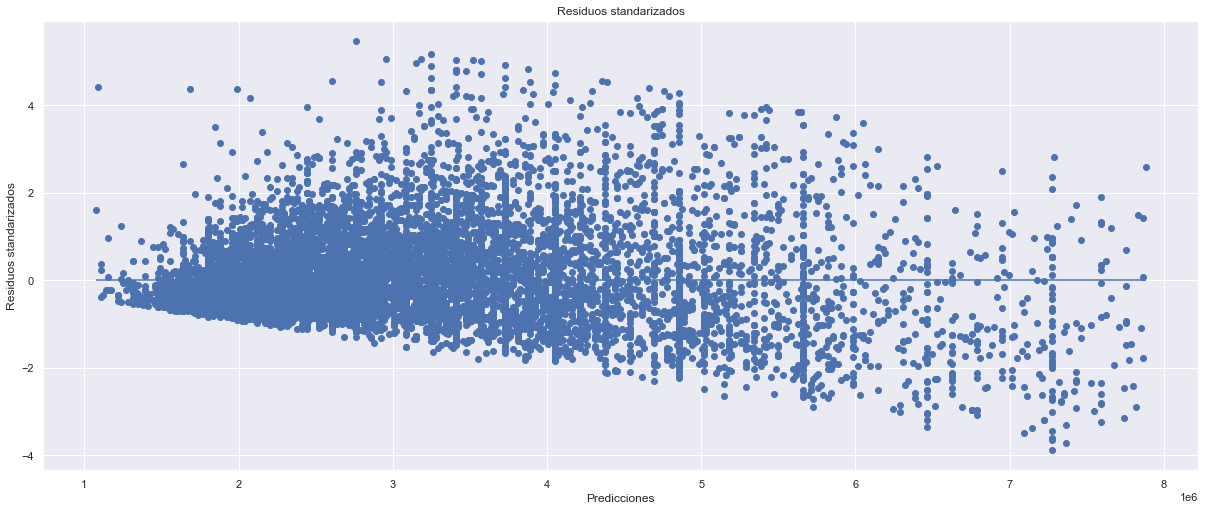

<Figure size 2160x2160 with 0 Axes>

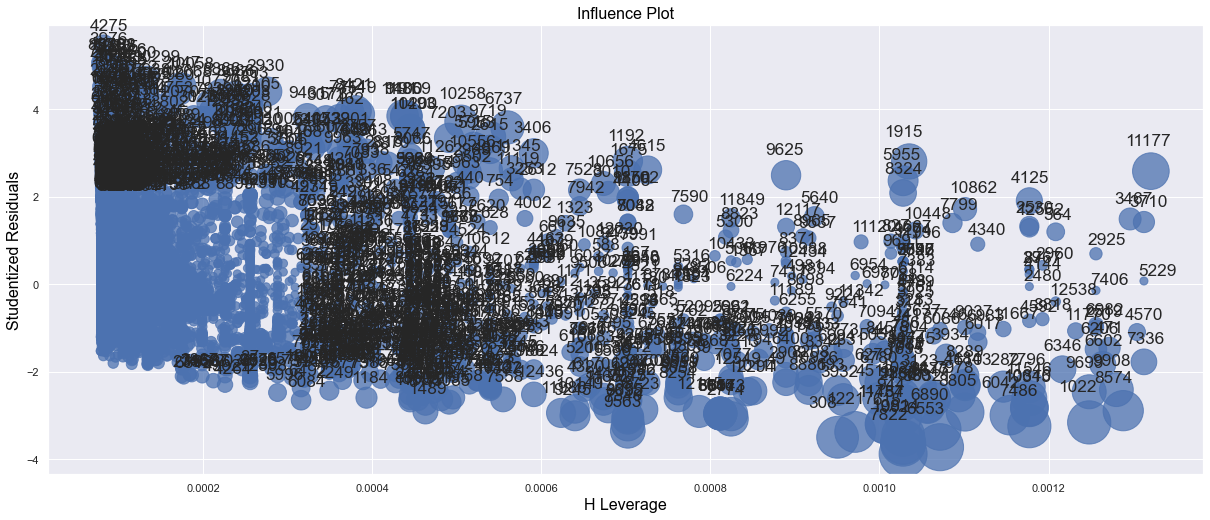

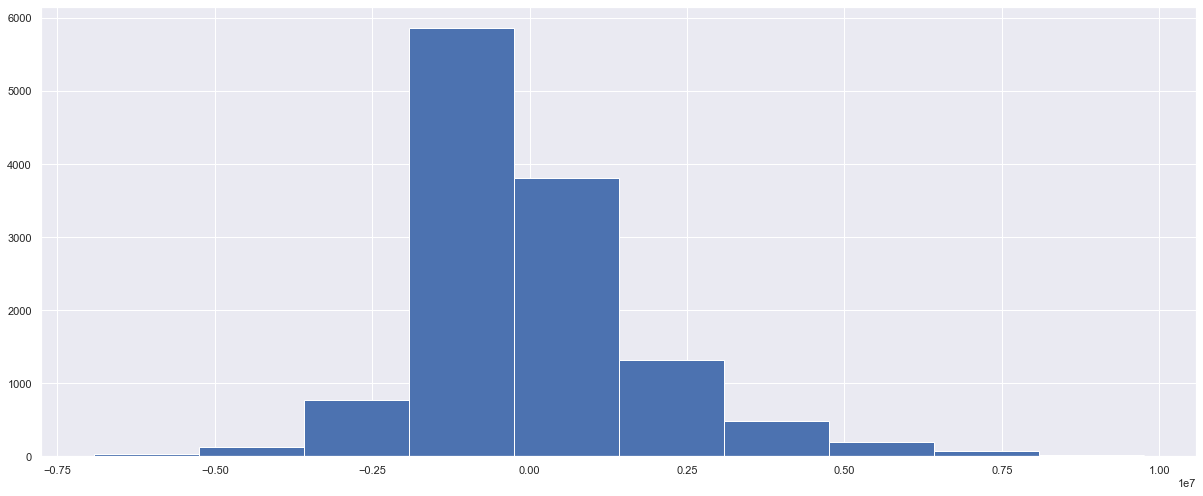

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x127ec7d90>,
 'r2': 0.31924108931255,
 'rmse': 1786408.1476245145,
 'adjusted': 0.3191874482353545,
 'standarized_residuals': 0       -0.661652
 1       -0.785880
 2       -0.428150
 3        0.591722
 4        0.785344
            ...   
 12728    0.263132
 12729   -0.204244
 12730    0.281539
 12731   -0.267502
 12732   -0.083126
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([2281981.33459066, 2603902.90751768, 1589849.95279755, ...,
        2797055.8512739 , 1927867.60437093, 3038497.03096917])}

In [42]:
run_analysis(['normalizado_metrostotales'], df)

VIF for normalizado_metrostotales 1.2081198090522813
VIF for tipodepropiedad_encoded 1.2081198090522816
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     3369.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:18:20   Log-Likelihood:            -2.0047e+05
No. Observations:               12693   AIC:                         4.010e+05
Df Residuals:                   12690   BIC:                         4.010e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

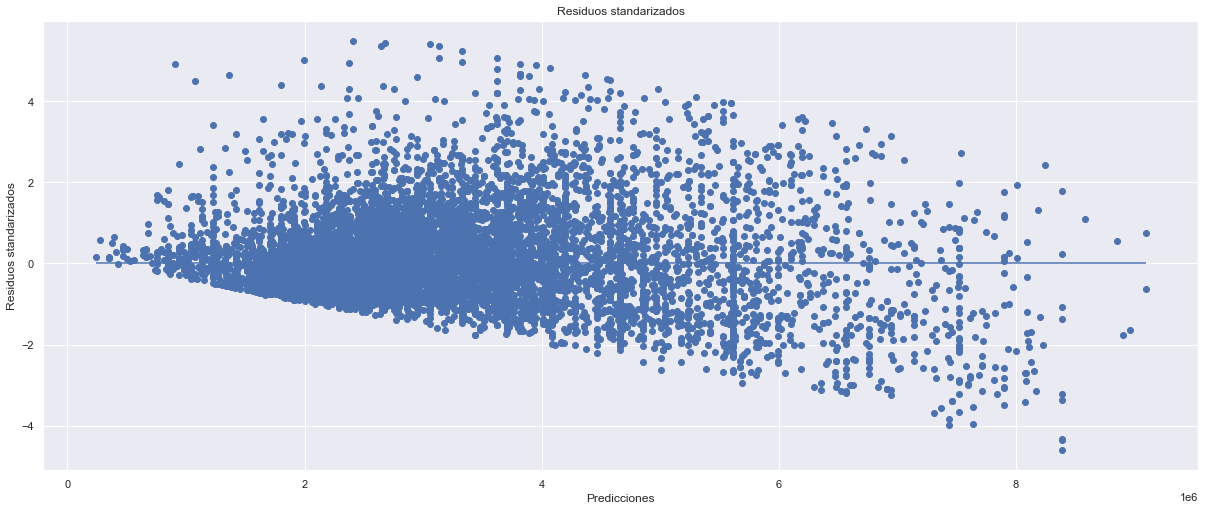

<Figure size 2160x2160 with 0 Axes>

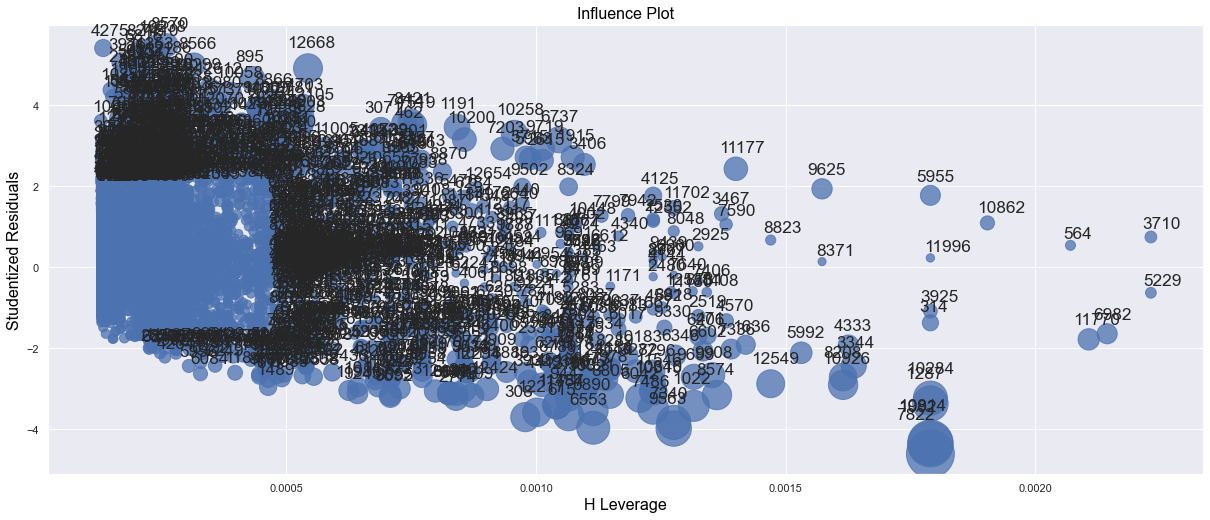

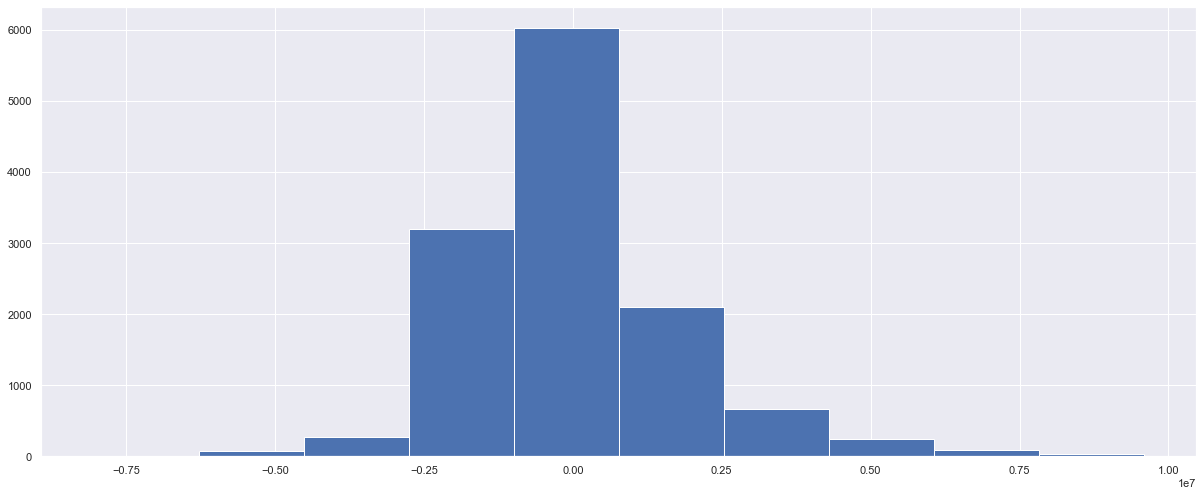

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1283dedc0>,
 'r2': 0.34682841209354165,
 'rmse': 1749837.285061437,
 'adjusted': 0.34672546936889126,
 'standarized_residuals': 0       -0.790133
 1       -0.453201
 2       -0.479018
 3        0.472522
 4        0.632978
            ...   
 12728    0.049110
 12729    0.123676
 12730    0.616229
 12731   -0.350533
 12732    0.218571
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([2482604.61777697, 1993028.81925769, 1663203.92029423, ...,
        2221698.7813459 , 2063376.35394859, 2507536.23395616])}

In [43]:
run_analysis(['normalizado_metrostotales', 'tipodepropiedad_encoded'], df)

In [44]:
df['log_metros_totales'] = np.log(df['metrostotales'])
df['squared_metros_totales'] = np.power(df['metrostotales'],2)
df['metrostotales_por_tipo'] = df['tipodepropiedad_encoded'] * df['normalizado_metrostotales']

VIF for normalizado_metrostotales 2.334189761632059
VIF for tipodepropiedad_encoded 1.4314040405480384
VIF for metrostotales_por_tipo 2.765593802180095
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     3156.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:18:53   Log-Likelihood:            -1.9964e+05
No. Observations:               12693   AIC:                         3.993e+05
Df Residuals:                   12689   BIC:                         3.993e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|    

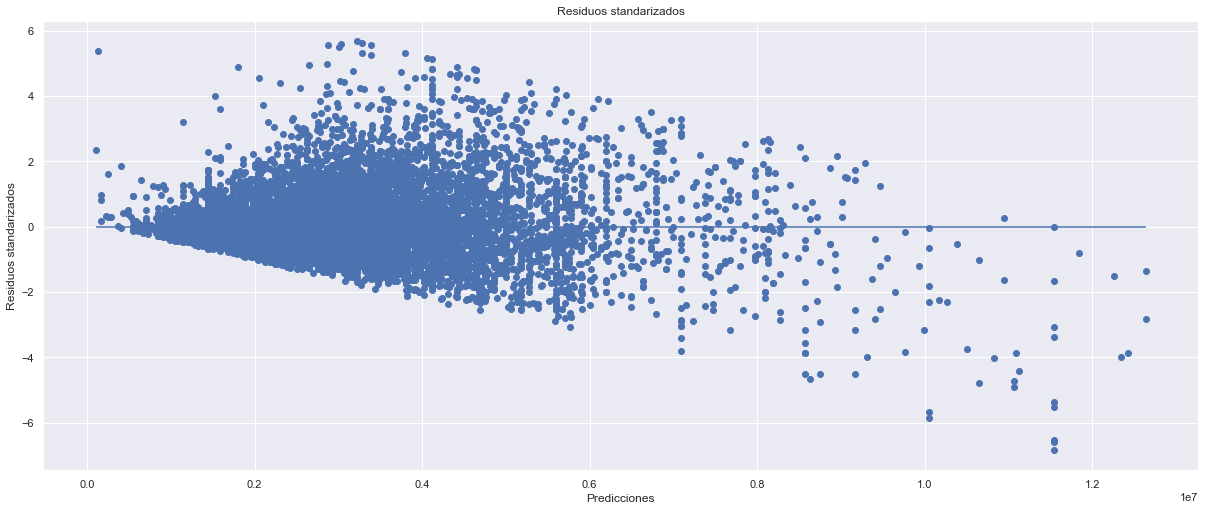

<Figure size 2160x2160 with 0 Axes>

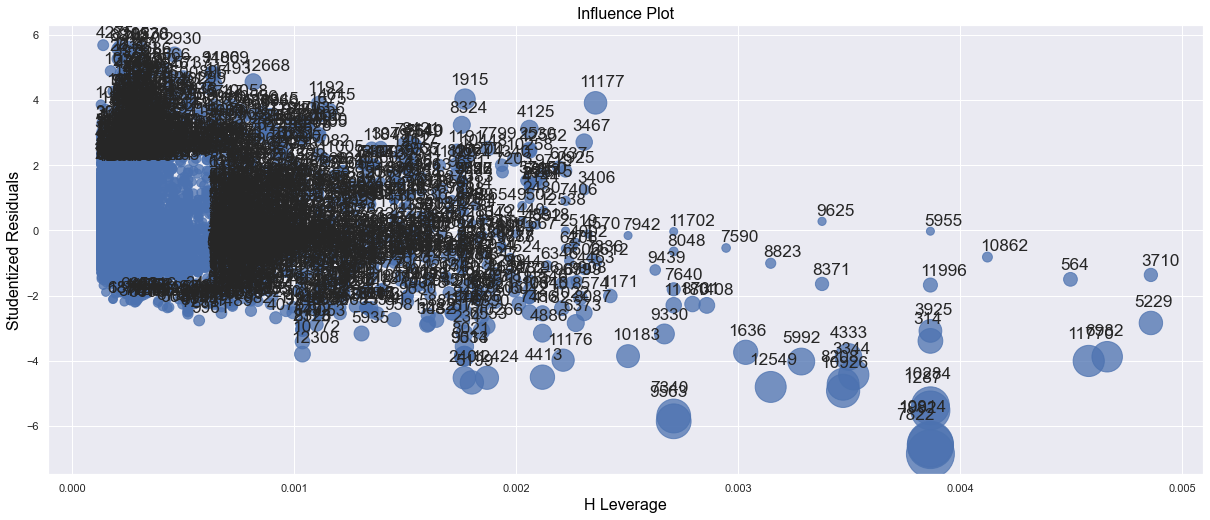

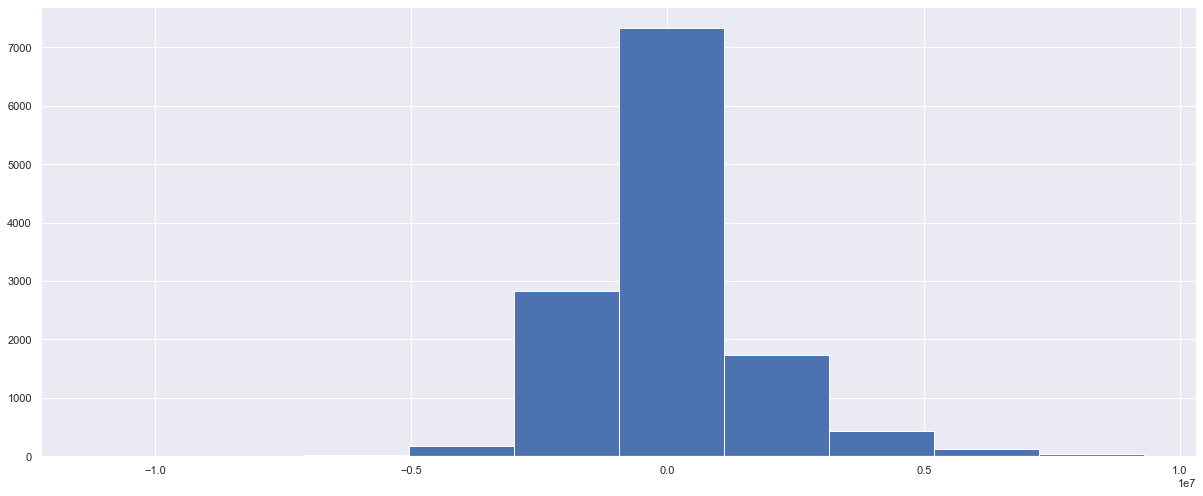

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x127c7e9d0>,
 'r2': 0.42732742801676915,
 'rmse': 1638465.1751921542,
 'adjusted': 0.42719203376064574,
 'standarized_residuals': 0       -0.751839
 1       -0.884089
 2       -0.139837
 3        0.531588
 4        0.559828
            ...   
 12728   -0.258894
 12729   -0.215956
 12730    0.320487
 12731   -0.139236
 12732   -0.026137
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([2331861.95585084, 2648549.38882845, 1054118.84148437, ...,
        2774893.85052311, 1678132.92059357, 2932824.42764143])}

In [45]:
run_analysis(['normalizado_metrostotales', 'tipodepropiedad_encoded', 'metrostotales_por_tipo'], df)

In [46]:
df['amenities_deluxe'] = df['piscina'] + df['gimnasio'] + df['usosmultiples']
df['amenities_deluxe_por_tipo'] = df['tipodepropiedad_encoded'] * df['amenities_deluxe']
df['metrostotales_por_tipo'] = df['tipodepropiedad_encoded'] * df['normalizado_metrostotales']

In [47]:
df['habitaciones_por_tipo'] = df['habitaciones']*df['tipodepropiedad_encoded']

VIF for metrostotales 3.389671312270116
VIF for tipodepropiedad_encoded 2.3845596637247617
VIF for metrostotales_por_tipo 1.8861409393258182
VIF for amenities_deluxe 1.1881945821713051
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2706.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:19:25   Log-Likelihood:            -1.9926e+05
No. Observations:               12693   AIC:                         3.985e+05
Df Residuals:                   12688   BIC:                         3.986e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    

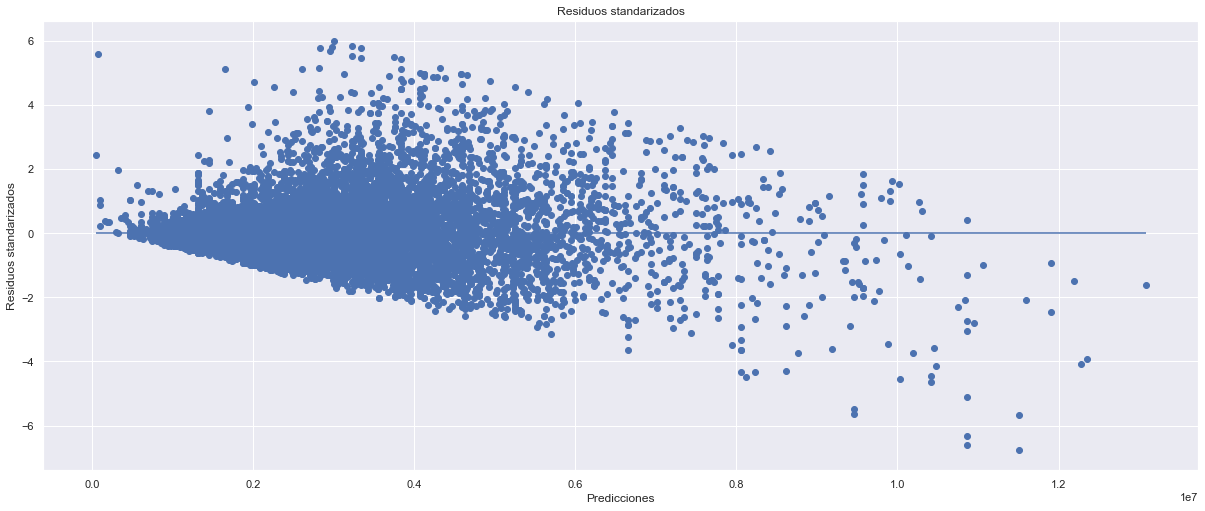

<Figure size 2160x2160 with 0 Axes>

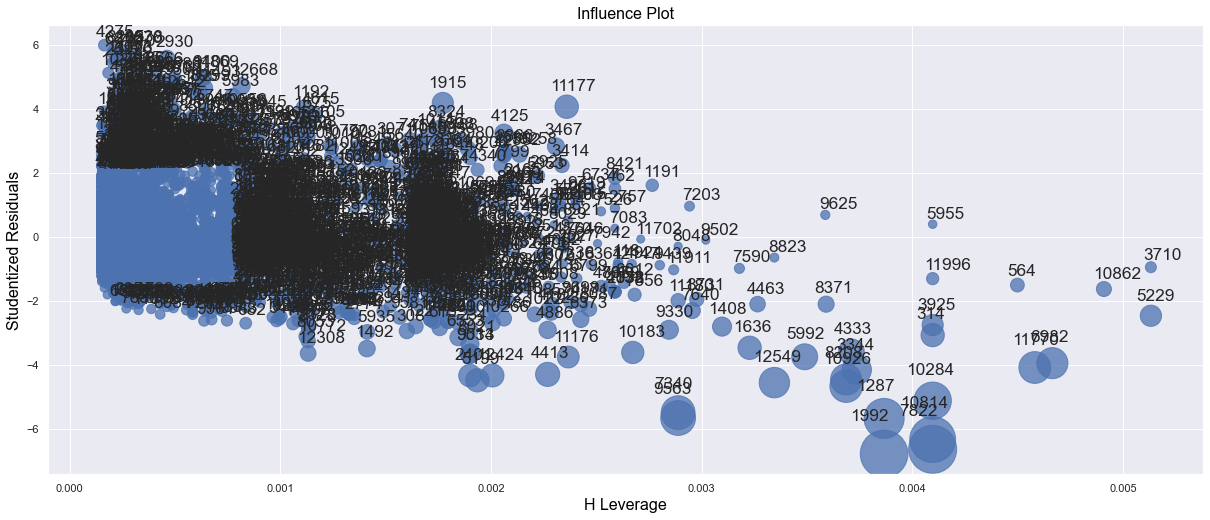

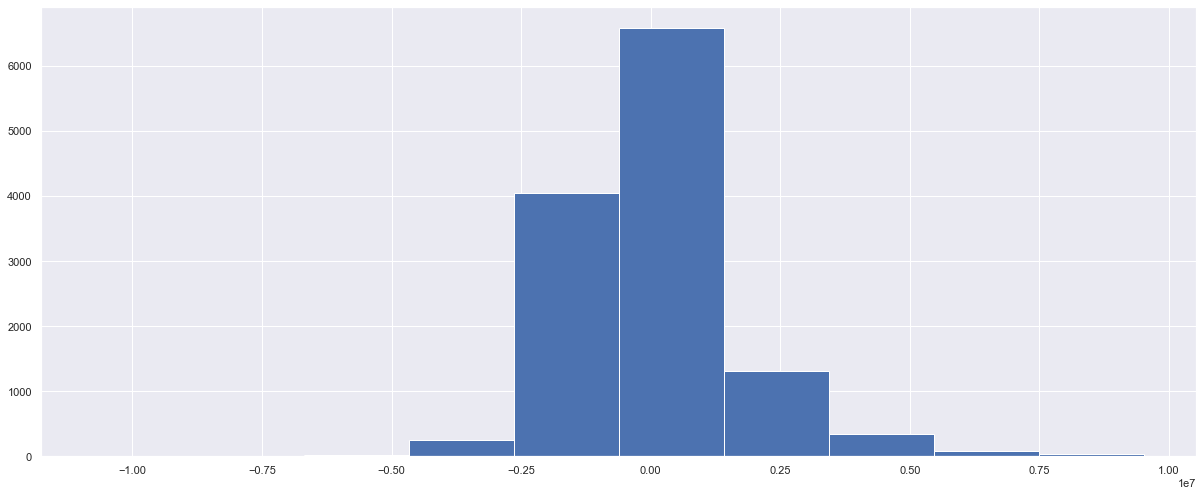

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1285d6b50>,
 'r2': 0.4603482133006801,
 'rmse': 1590526.2208971297,
 'adjusted': 0.460178083481418,
 'standarized_residuals': 0       -0.665379
 1       -0.885184
 2       -0.078558
 3       -0.548782
 4        0.718288
            ...   
 12728   -0.094675
 12729   -0.196475
 12730    0.356224
 12731   -0.056632
 12732   -0.405409
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([2158303.53536341, 2607908.12769879,  949948.4222402 , ...,
        2733416.23964748, 1540075.33795153, 3534813.1116081 ])}

In [48]:
run_analysis(['metrostotales', 'tipodepropiedad_encoded', 'metrostotales_por_tipo', 'amenities_deluxe'], df)

VIF for metrostotales 3.44331543560357
VIF for tipodepropiedad_encoded 2.4973192007535836
VIF for metrostotales_por_tipo 1.8998597481907953
VIF for amenities_deluxe 1.3098489418779087
VIF for amenities_deluxe_por_tipo 1.1660640087324456
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2165.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:20:03   Log-Likelihood:            -1.9926e+05
No. Observations:               12693   AIC:                         3.985e+05
Df Residuals:                   12687   BIC:                         3.986e+05
Df Model:                           5                                         
Covariance Type:            nonrobust               

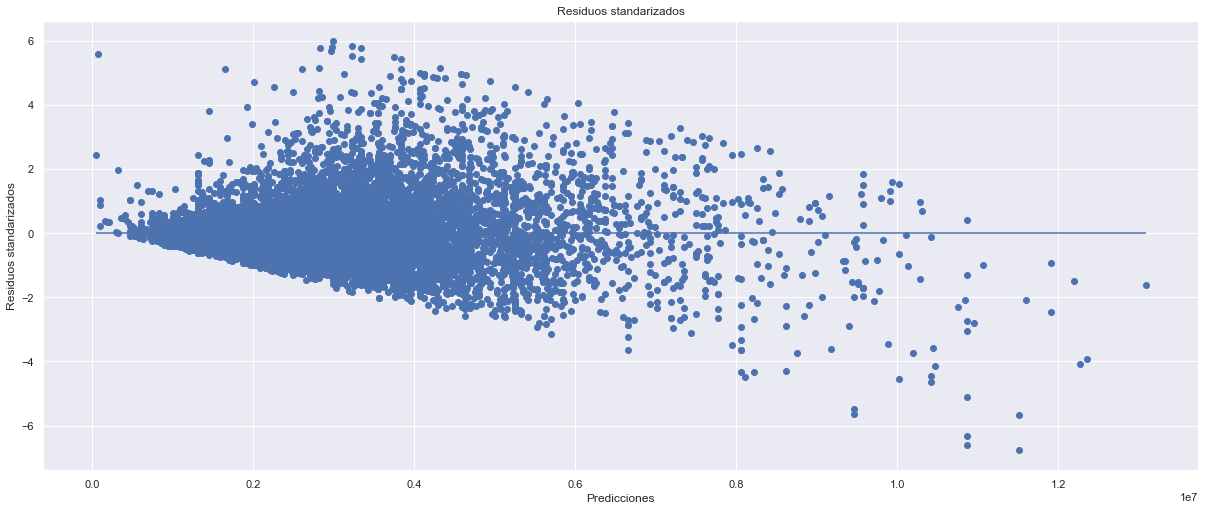

<Figure size 2160x2160 with 0 Axes>

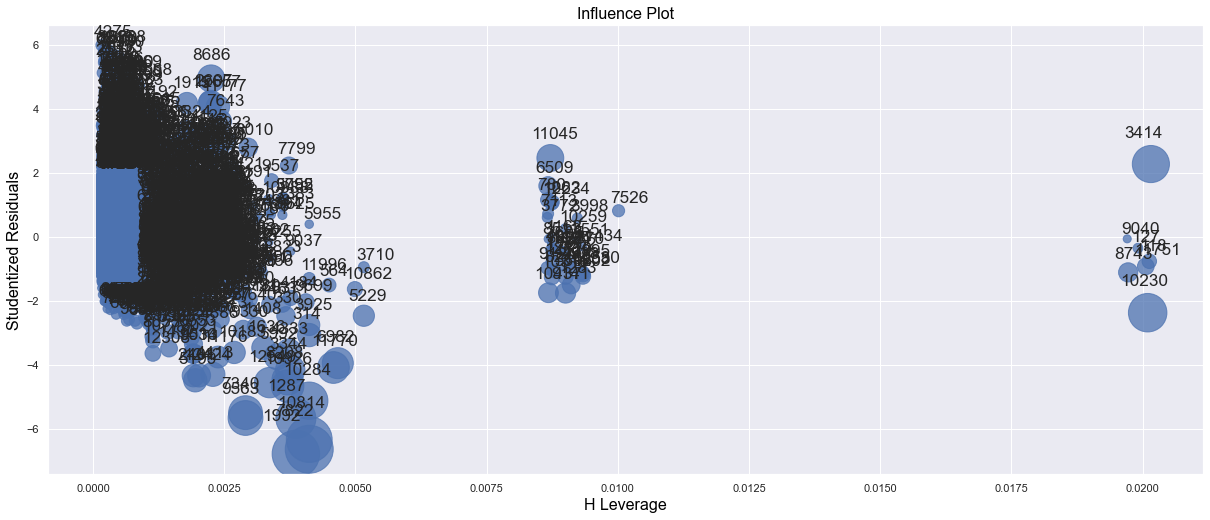

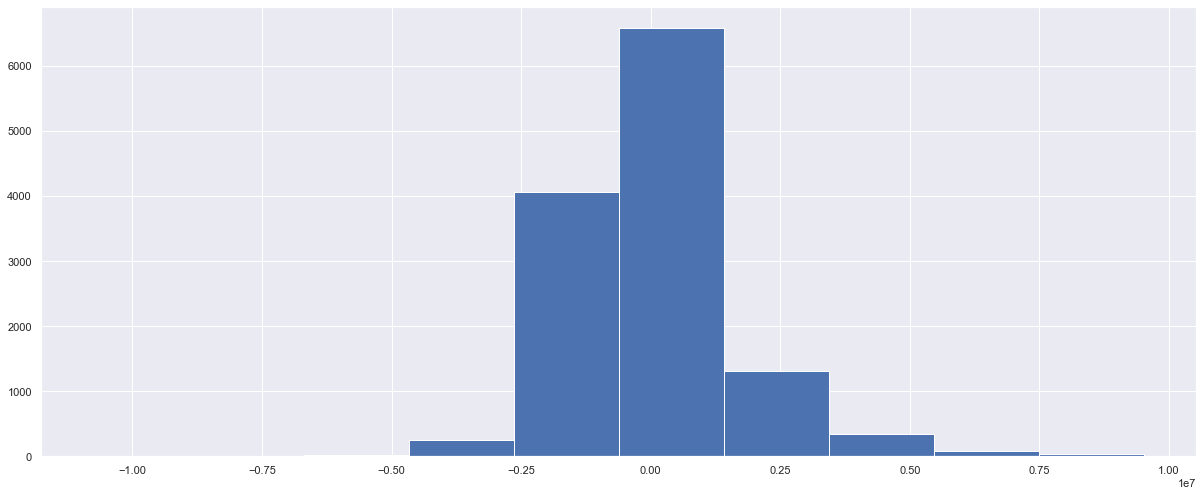

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x127b62880>,
 'r2': 0.460349668164031,
 'rmse': 1590524.0769221408,
 'adjusted': 0.46013698970110206,
 'standarized_residuals': 0       -0.665149
 1       -0.885715
 2       -0.078419
 3       -0.551112
 4        0.718590
            ...   
 12728   -0.094310
 12729   -0.197014
 12730    0.355684
 12731   -0.056448
 12732   -0.397561
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([2157934.77152117, 2608750.87882252,  949727.08878983, ...,
        2734276.33360626, 1539782.00361211, 3522330.06787885])}

In [49]:
run_analysis(['metrostotales', 'tipodepropiedad_encoded', 'metrostotales_por_tipo', 'amenities_deluxe', 'amenities_deluxe_por_tipo'], df)

# Incorporar habitaciones

In [50]:
def segmentar_habitaciones(habitaciones):
    if habitaciones in (1,2,3):
        return habitaciones
    else:
        return 4
df['habitaciones_segmento'] = df['habitaciones'].apply(segmentar_habitaciones)

In [51]:
df.groupby('habitaciones_segmento').count()['id']

habitaciones_segmento
1.0     435
2.0    4940
3.0    5494
4.0    1824
Name: id, dtype: int64

In [52]:
segmentos = pd.get_dummies(df['habitaciones_segmento'], drop_first=True)
segmentos.rename(columns={x:f'segmento_{str(x)}'for x in segmentos.columns}, inplace=True)
features_segmentos = list(segmentos.columns.values)
segmentos.head()

segmento_2.0  segmento_3.0  segmento_4.0
0             1             0             0
1             0             1             0
2             1             0             0
3             1             0             0
4             1             0             0

In [53]:
print(features_segmentos)

['segmento_2.0', 'segmento_3.0', 'segmento_4.0']


In [54]:
segmentado = pd.concat([df, segmentos], axis=1)

In [55]:
segmentado[features_segmentos+['tipodepropiedad_encoded']].dtypes

segmento_2.0               uint8
segmento_3.0               uint8
segmento_4.0               uint8
tipodepropiedad_encoded    int64
dtype: object

In [56]:
interactions_segmento = []
for feature in features_segmentos:
    segmentado[f'interation_{feature}'] = segmentado[feature] * df['tipodepropiedad_encoded']
    interactions_segmento.append(f'interation_{feature}')

In [57]:
interactions_segmento_metros = []
for feature in features_segmentos:
    segmentado[f'interation_metros_{feature}'] = segmentado[feature] * df['metrostotales']
    interactions_segmento_metros.append(f'interation_metros_{feature}')

VIF for metrostotales 95.57011800309279
VIF for tipodepropiedad_encoded 3.1468557611146255
VIF for metrostotales_por_tipo 4.3403683068865595
VIF for segmento_2.0 5.022725260729857
VIF for segmento_3.0 9.3050059164332
VIF for segmento_4.0 13.016313625137522
VIF for interation_metros_segmento_2.0 21.818079095106235
VIF for interation_metros_segmento_3.0 63.52704026071748
VIF for interation_metros_segmento_4.0 39.30181714204289
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1077.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:20:44   Log-Likelihood:            -1.9957e+05
No. Observations:               12693   AIC:                         3.992e+05
Df Residuals:     

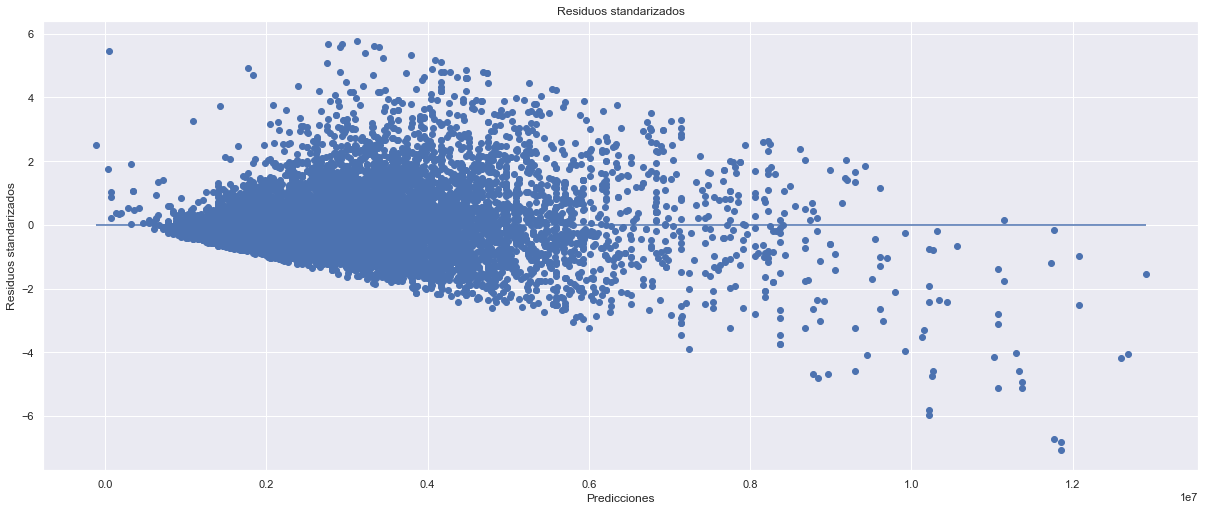

<Figure size 2160x2160 with 0 Axes>

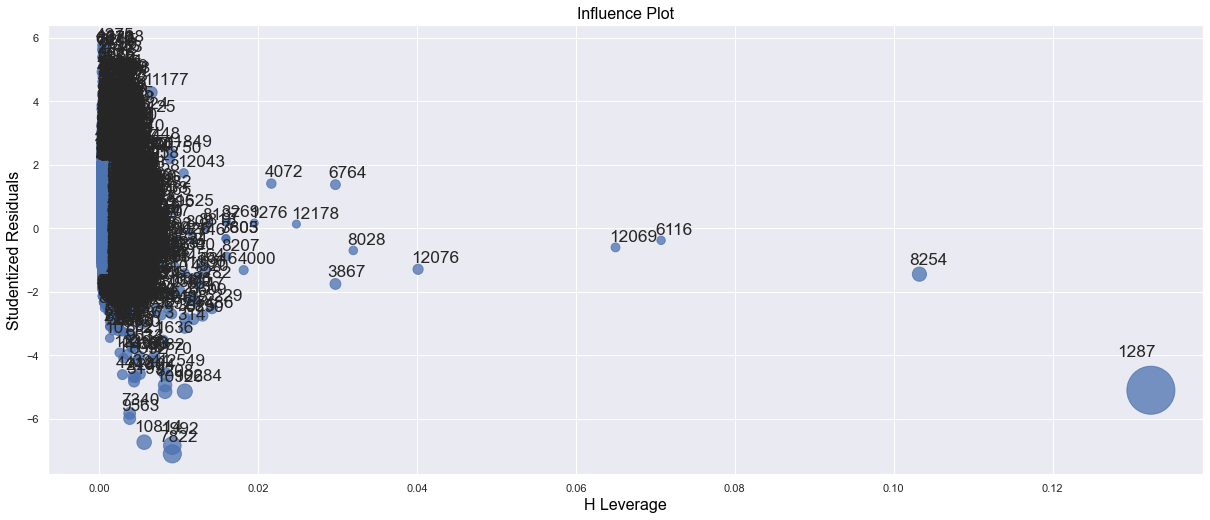

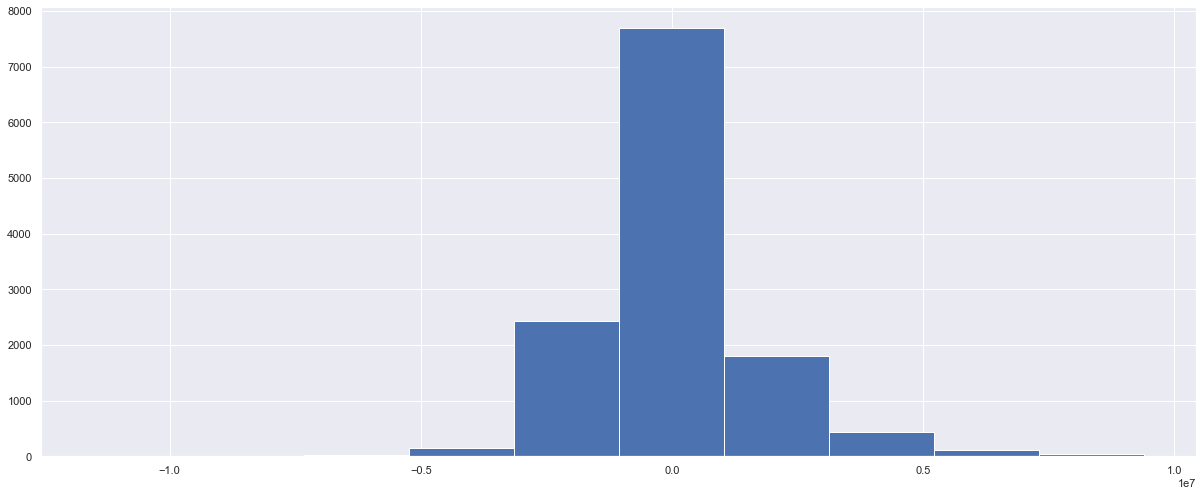

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x128443d90>,
 'r2': 0.43322078974142453,
 'rmse': 1630012.6670057988,
 'adjusted': 0.43281859681448875,
 'standarized_residuals': 0       -0.751066
 1       -0.804414
 2       -0.108203
 3        0.532578
 4        0.546799
            ...   
 12728   -0.222969
 12729   -0.366443
 12730    0.397141
 12731   -0.121120
 12732   -0.149385
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([2324246.69691362, 2511204.31173796, 1001372.2275033 , ...,
        2652655.73242098, 1647427.20093625, 3133499.94710234])}

In [58]:
run_analysis(['metrostotales', 'tipodepropiedad_encoded', 'metrostotales_por_tipo'] + features_segmentos + interactions_segmento_metros, segmentado)

In [59]:
df['habitacion_tamano'] = df['metrostotales']/df['habitaciones']

VIF for metrostotales 19.544194942243095
VIF for tipodepropiedad_encoded 2.534291520477631
VIF for metrostotales_por_tipo 1.9930939937435472
VIF for habitacion_tamano 12.991403219545042
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     2380.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:21:40   Log-Likelihood:            -1.9962e+05
No. Observations:               12693   AIC:                         3.993e+05
Df Residuals:                   12688   BIC:                         3.993e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef   

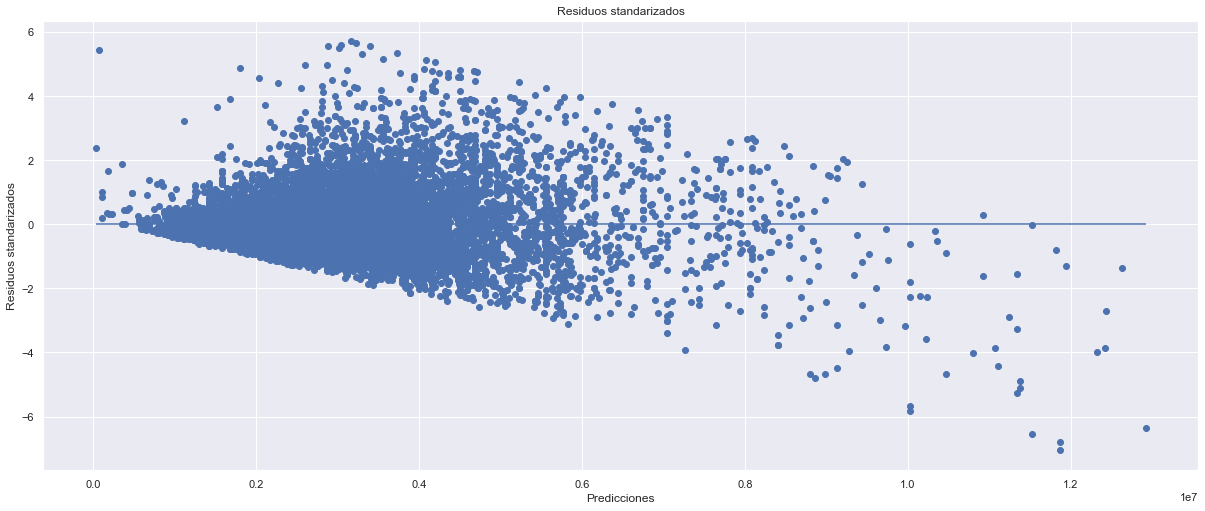

<Figure size 2160x2160 with 0 Axes>

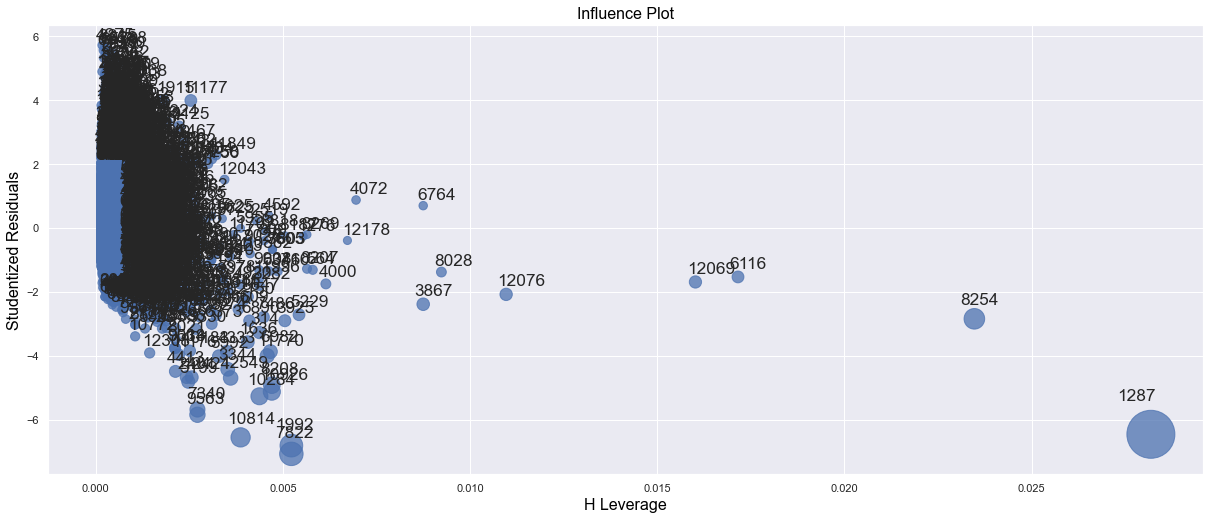

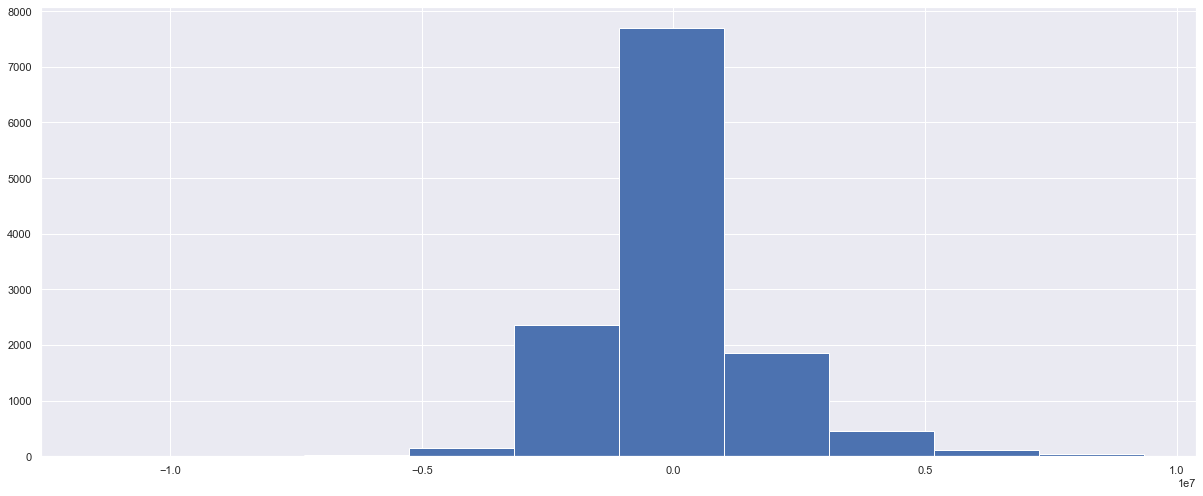

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x127c450a0>,
 'r2': 0.4286370655702344,
 'rmse': 1636590.6103610827,
 'adjusted': 0.4284569385417256,
 'standarized_residuals': 0       -0.765462
 1       -0.889517
 2       -0.126905
 3        0.513423
 4        0.528467
            ...   
 12728   -0.227916
 12729   -0.170448
 12730    0.315015
 12731   -0.138929
 12732    0.002860
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([2352747.53329653, 2655775.56403624, 1032691.05892123, ...,
        2784449.83520687, 1677369.8022208 , 2885319.22909651])}

In [60]:
run_analysis(['metrostotales', 'tipodepropiedad_encoded', 'metrostotales_por_tipo', 'habitacion_tamano'], df)

# Areas

In [61]:
dummy_areas = pd.get_dummies(df.ciudad, drop_first=True)
areas = [str(x) for x in dummy_areas.columns]
dummy_areas.rename(columns={x:str(x) for x in dummy_areas.columns}, inplace=True)

In [62]:
dummy_areas.head()

Azcapotzalco  Benito Juárez  Coyoacán  Cuajimalpa de Morelos  Cuauhtémoc  \
0             0              0         1                      0           0   
1             0              0         0                      0           0   
2             0              0         0                      0           0   
3             0              0         0                      0           0   
4             0              1         0                      0           0   

   Gustavo A. Madero  Iztacalco  Iztapalapa  La Magdalena Contreras  \
0                  0          0           0                       0   
1                  0          1           0                       0   
2                  0          1           0                       0   
3                  0          0           0                       0   
4                  0          0           0                       0   

   Miguel Hidalgo  Tlalpan  Tláhuac  Venustiano Carranza  Xochimilco  
0               0        0        0                    0           0  
1               0        0        0                    0           0  
2               0        0        0                    0           0  
3               0        0        0                    0           0  
4               0        0        0                    0           0

In [63]:
df = pd.concat([df, dummy_areas], axis=1)

VIF for normalizado_metrostotales 3.336792147995979
VIF for tipodepropiedad_encoded 2.6556983071495655
VIF for metrostotales_por_tipo 3.2391995296747615
VIF for amenities_deluxe 1.1618125749719395
VIF for Azcapotzalco 1.0915811802649469
VIF for Benito Juárez 1.1180272350660205
VIF for Coyoacán 1.2984300529968513
VIF for Cuajimalpa de Morelos 1.0863937375715078
VIF for Cuauhtémoc 1.119451486466873
VIF for Gustavo A. Madero 1.2238993905528666
VIF for Iztacalco 1.0795768247244055
VIF for Iztapalapa 1.2246653957200353
VIF for La Magdalena Contreras 1.086433960454761
VIF for Miguel Hidalgo 1.0701226961679615
VIF for Tlalpan 1.19375976526389
VIF for Tláhuac 1.0274690846041727
VIF for Venustiano Carranza 1.0777583355219456
VIF for Xochimilco 1.0935049285254497
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.520

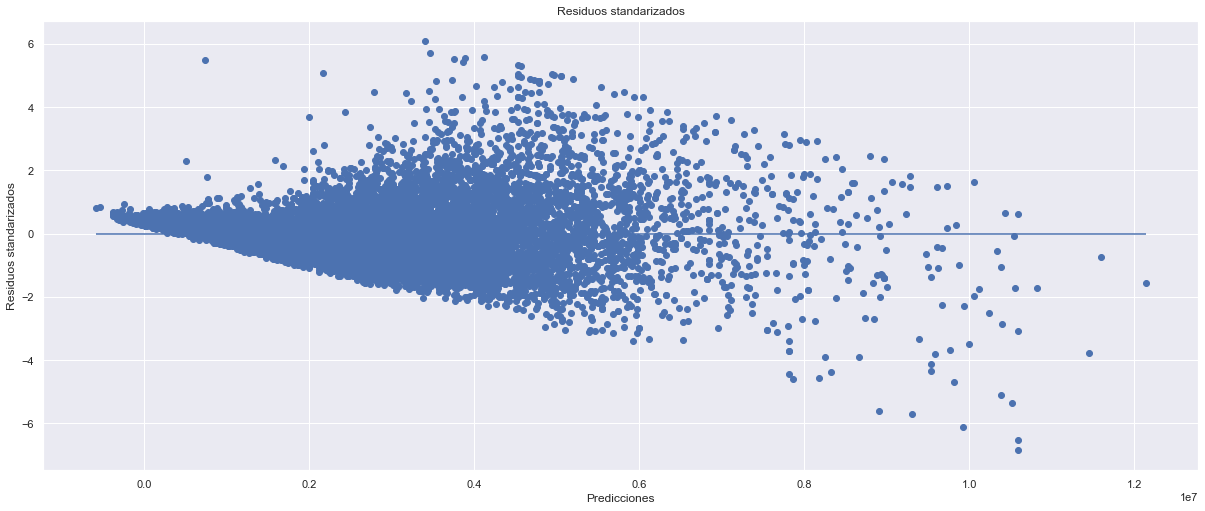

<Figure size 2160x2160 with 0 Axes>

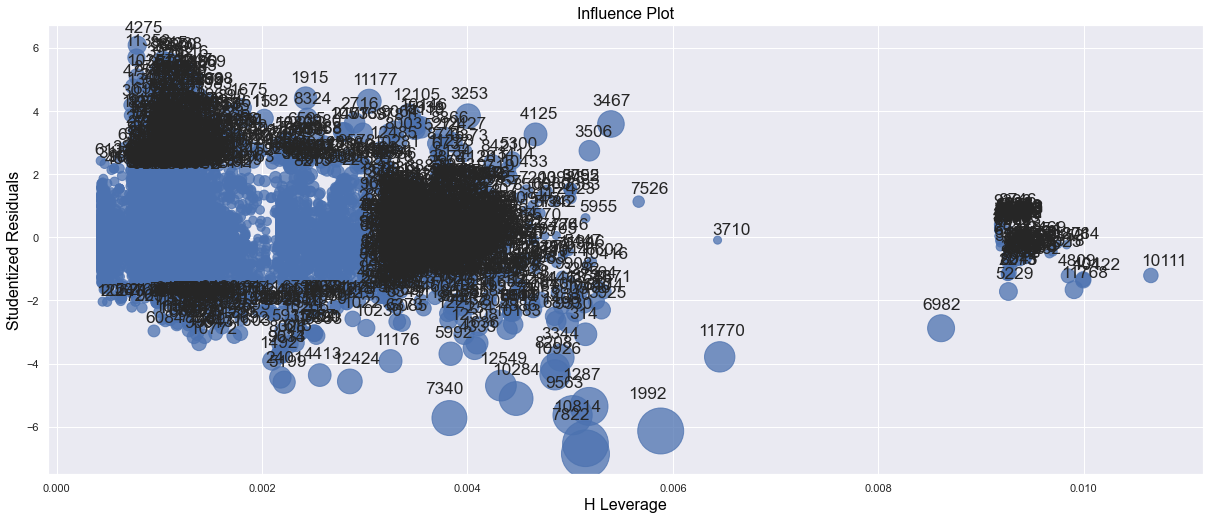

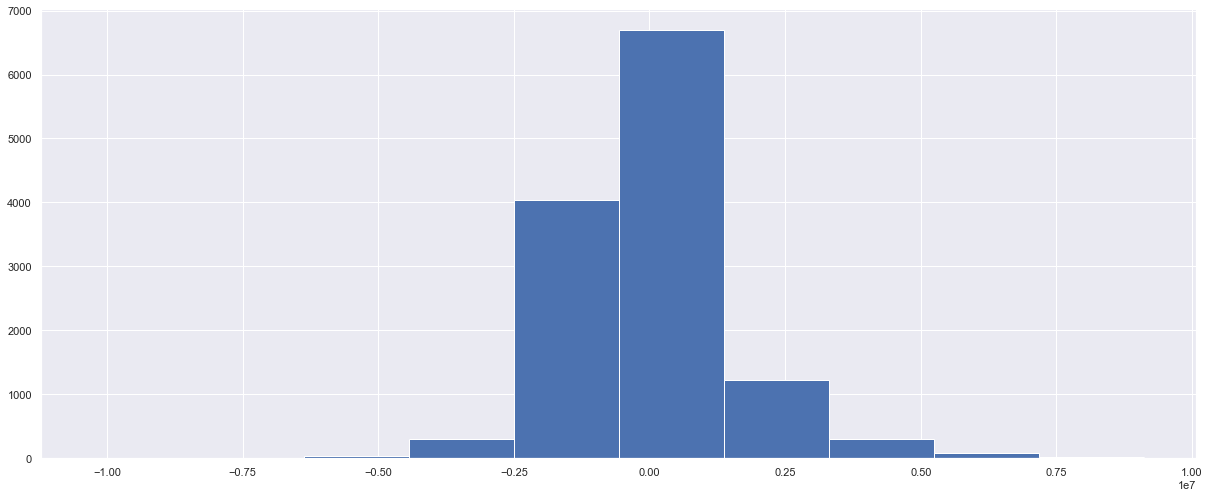

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1281271f0>,
 'r2': 0.5211063441062962,
 'rmse': 1498316.5112076157,
 'adjusted': 0.5204262047812145,
 'standarized_residuals': 0       -0.593771
 1       -0.647595
 2        0.441073
 3       -0.547688
 4        0.633543
            ...   
 12728   -0.180477
 12729   -0.825809
 12730   -0.476547
 12731    0.498630
 12732    0.065741
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([1989656.72439733, 2170302.91980686,  164132.39035533, ...,
        4014018.73842202,  702894.47413744, 2791499.07035709])}

In [92]:
run_analysis(['normalizado_metrostotales', 
              'tipodepropiedad_encoded',
              'metrostotales_por_tipo',
              'amenities_deluxe'] + areas, df)

In [65]:
presencia_en_zona = df.groupby(['ciudad'], as_index=False).agg({'tipodepropiedad_encoded':sum, 'id':'count'}).rename(columns={'tipodepropiedad_encoded':'casas', 'id':'deptos'})
presencia_en_zona['prob_1'] = presencia_en_zona['casas']/(presencia_en_zona['deptos'] +presencia_en_zona['casas'])

In [66]:
con_presencia_en_zona = df.merge(presencia_en_zona)

VIF for metrostotales 3.476267413429491
VIF for tipodepropiedad_encoded 1.8002740044291567
VIF for metrostotales_por_tipo 2.9728882505421788
VIF for amenities_deluxe 1.1353946979138816
VIF for Azcapotzalco 1.351835839484617
VIF for Benito Juárez 1.801621513099826
VIF for Coyoacán 2.9944397795576423
VIF for Cuajimalpa de Morelos 1.2523836431543958
VIF for Cuauhtémoc 1.3704154626684963
VIF for Gustavo A. Madero 2.4524517884189097
VIF for Iztacalco 1.4605751530720974
VIF for Iztapalapa 2.2094384993104956
VIF for La Magdalena Contreras 1.5309895681293766
VIF for Miguel Hidalgo 1.4441564050737528
VIF for Tlalpan 2.351982352551552
VIF for Tláhuac 1.1023649602337686
VIF for Venustiano Carranza 1.3177459243304566
VIF for Xochimilco 1.630047283925898
VIF for prob_1 17.41247521498426
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:  

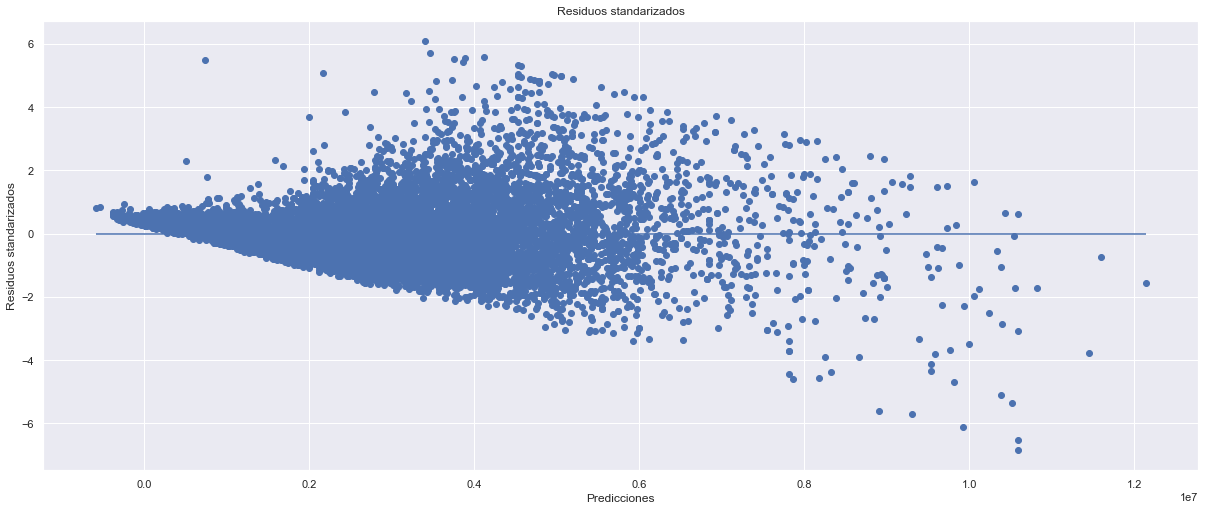

<Figure size 2160x2160 with 0 Axes>

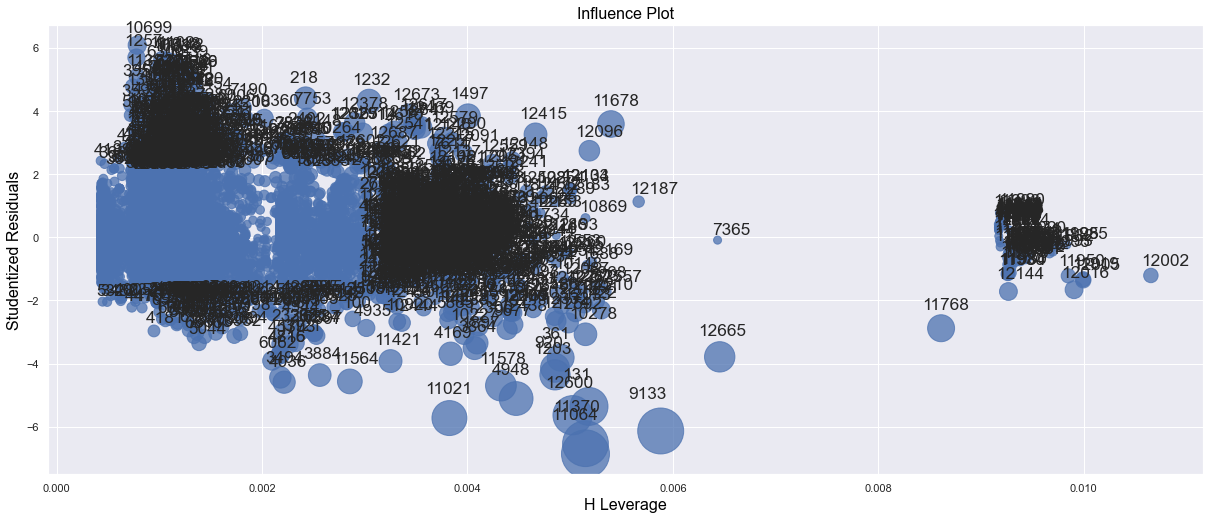

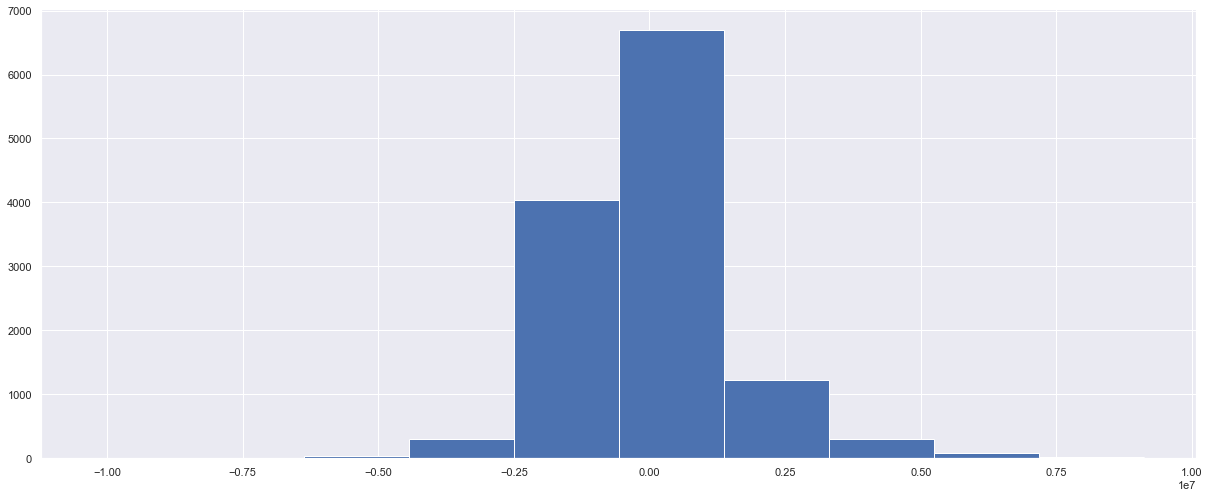

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x127c751f0>,
 'r2': 0.5211063441062963,
 'rmse': 1498316.5112076155,
 'adjusted': 0.5203883626132023,
 'standarized_residuals': 0       -0.593771
 1        1.548745
 2       -0.582937
 3       -0.475825
 4        1.982743
            ...   
 12688   -1.082160
 12689   -0.243674
 12690   -0.220766
 12691    2.220143
 12692   -1.414175
 Name: precio, Length: 12693, dtype: float64,
 'fitted': array([1989656.72439732, 5879489.10491649, 3923589.76537189, ...,
        5930777.9589232 , 4773523.41569648, 6118881.04833931])}

In [67]:
run_analysis(['metrostotales', 
              'tipodepropiedad_encoded',
              'metrostotales_por_tipo',
              'amenities_deluxe'] + areas + ['prob_1'], con_presencia_en_zona)

No aporta pero reemplaza

VIF for normalizado_metrostotales 3.4762674134294924
VIF for tipodepropiedad_encoded 1.8002740044291563
VIF for metrostotales_por_tipo 2.9728882505421788
VIF for amenities_deluxe 1.1353946979138816
VIF for Azcapotzalco 1.362311806963165
VIF for Benito Juárez 1.392677105197264
VIF for Coyoacán 2.882484073500063
VIF for Cuajimalpa de Morelos 1.2043609738771568
VIF for Cuauhtémoc 1.2780514904431477
VIF for Gustavo A. Madero 2.3253814570995233
VIF for Iztacalco 1.4272013625024005
VIF for Iztapalapa 2.1259393576412124
VIF for La Magdalena Contreras 1.494590847691885
VIF for Miguel Hidalgo 1.130839358983608
VIF for Tlalpan 2.310135667994593
VIF for Tláhuac 1.102147580133233
VIF for Venustiano Carranza 1.32319149672234
VIF for Xochimilco 1.571060499364647
VIF for prob_1 11.496061535405946
                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.521
Model:                            OLS   Adj. R-sq

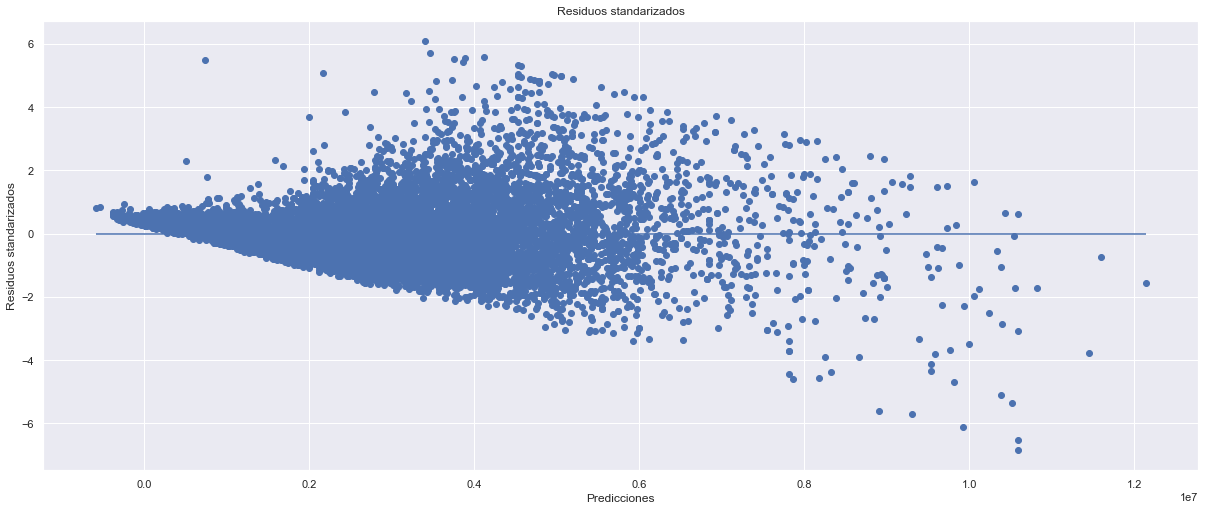

<Figure size 2160x2160 with 0 Axes>

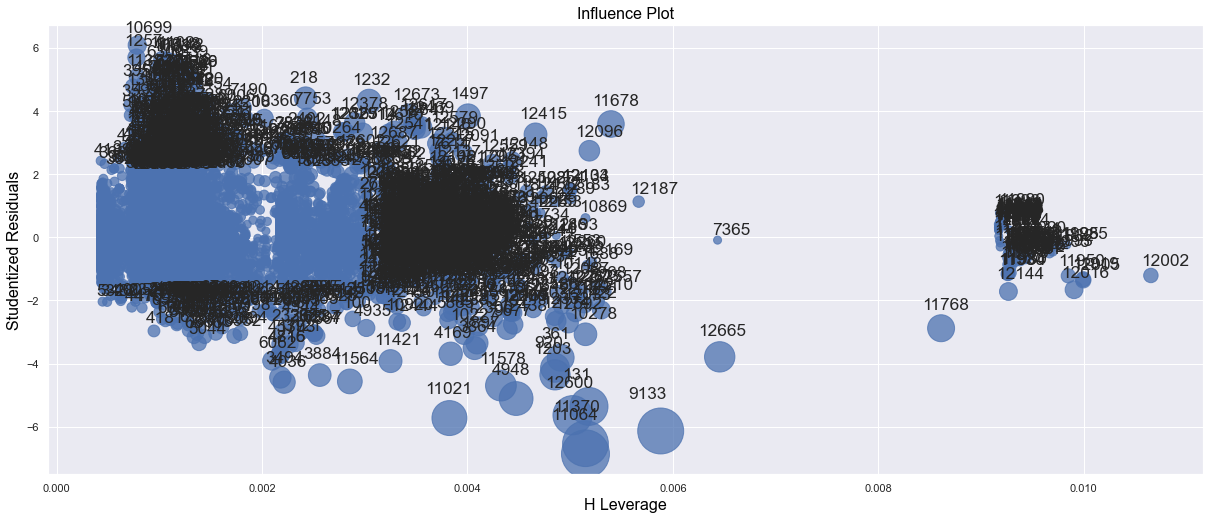

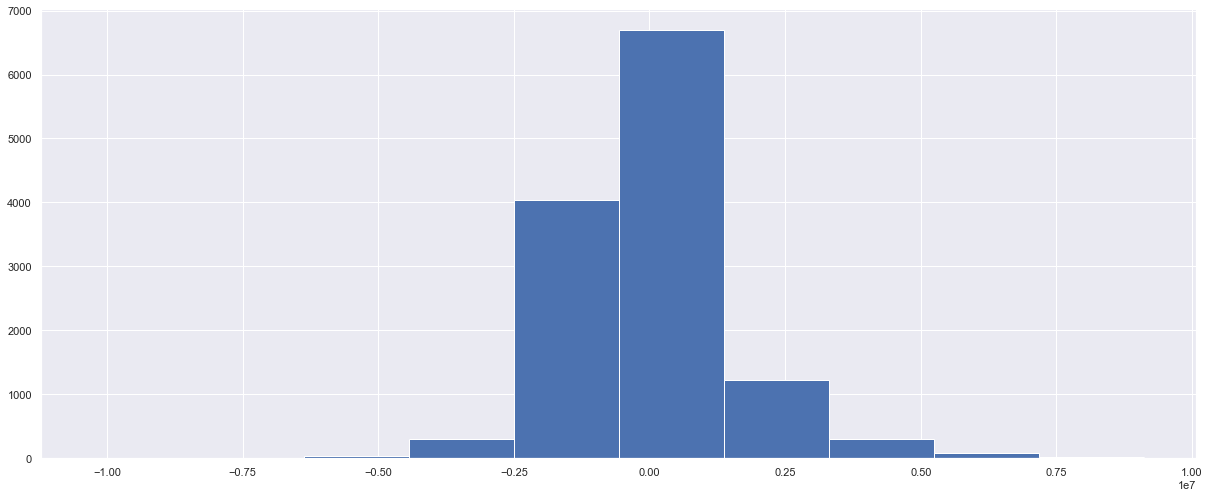

In [68]:
analysis_result = run_analysis(['normalizado_metrostotales', 
              'tipodepropiedad_encoded',
              'metrostotales_por_tipo',
              'amenities_deluxe'] + areas + ['prob_1'], con_presencia_en_zona)

In [69]:
analysis_result.keys()

dict_keys(['model', 'r2', 'rmse', 'adjusted', 'standarized_residuals', 'fitted'])

In [70]:
reduced = df.sample(1000)

Text(0, 0.5, 'Metros totales')

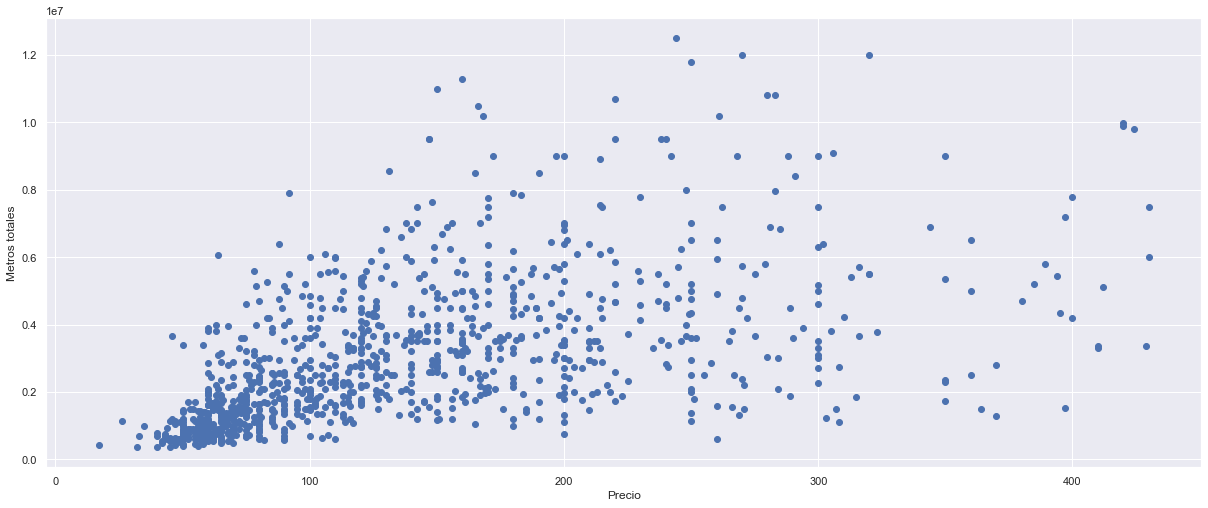

In [81]:
plt.scatter(reduced['metrostotales'] ,reduced['precio'])
plt.xlabel('Precio')
plt.ylabel('Metros totales')

In [72]:
pd.DataFrame(np.corrcoef([reduced['precio'],reduced['metrostotales'],np.log(reduced['metrostotales']), 1/np.log(reduced['metrostotales']), np.log(reduced['metrostotales']), np.power(reduced['metrostotales'],3)]))

0         1         2         3         4         5
0  1.000000  0.548746  0.595134 -0.593716  0.595134  0.384616
1  0.548746  1.000000  0.953623 -0.905588  0.953623  0.878073
2  0.595134  0.953623  1.000000 -0.989834  1.000000  0.715207
3 -0.593716 -0.905588 -0.989834  1.000000 -0.989834 -0.636976
4  0.595134  0.953623  1.000000 -0.989834  1.000000  0.715207
5  0.384616  0.878073  0.715207 -0.636976  0.715207  1.000000

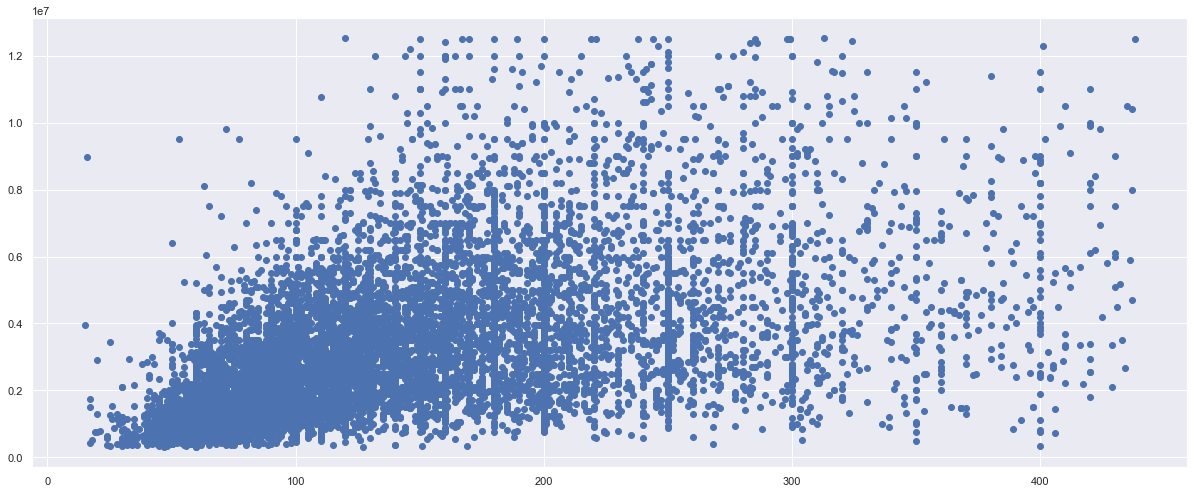

In [73]:
plt.scatter(df['metrostotales'], df['precio'])

In [75]:
df['normalized_squared_metros_totales'] = (df['squared_metros_totales']-np.mean(df['squared_metros_totales']))/np.std(df['squared_metros_totales'])

In [76]:
df['squared_metros_totales'] = np.power(df['metrostotales'], 2)

In [77]:
df['normalized_squared_metros_totales'] = (df['squared_metros_totales']-np.mean(df['squared_metros_totales']))/np.std(df['squared_metros_totales'])

In [78]:
df['precio'].value_counts().sort_values()

5510000.0      1
3915000.0      1
2788000.0      1
828630.0       1
8333000.0      1
            ... 
4500000.0    143
1500000.0    148
3200000.0    153
3500000.0    200
2500000.0    201
Name: precio, Length: 2328, dtype: int64

In [83]:
df['precio'].nunique(), len(df)

(2328, 12693)

# Pensando un submodelo por zonas

In [86]:
dummy_zonas = pd.get_dummies(df.idzona, drop_first=True)
zonas = [str(x) for x in dummy_zonas.columns]
dummy_zonas.rename(columns={x:str(x) for x in dummy_zonas.columns}, inplace=True)
con_zonas = pd.concat([df,dummy_zonas], axis=1)

In [137]:
por_zona = df.groupby('idzona', as_index=False).count()[['idzona','id']]
len(por_zona[por_zona.id>50]), len(por_zona)

(46, 1057)

In [138]:
len(df)

12693

In [142]:
filtrando_por_zona=df[df.idzona.isin(por_zona[por_zona.id>50]['idzona'])]

In [143]:
len(filtrando_por_zona)

5294

In [145]:
dummy_zonas = pd.get_dummies(filtrando_por_zona.idzona, drop_first=True)
zonas = [str(x) for x in dummy_zonas.columns]
dummy_zonas.rename(columns={x:str(x) for x in dummy_zonas.columns}, inplace=True)
con_zonas = pd.concat([filtrando_por_zona,dummy_zonas], axis=1)

VIF for normalizado_metrostotales 2.717128068911735
VIF for tipodepropiedad_encoded 2.436595260112148
VIF for metrostotales_por_tipo 2.6662741632509968
VIF for amenities_deluxe 1.467613372874819
VIF for 23191.0 1.1282351995277582
VIF for 23263.0 1.0517790683347168
VIF for 23343.0 1.0375169415490082
VIF for 23365.0 1.0271731182561752
VIF for 23533.0 1.0336375836612324
VIF for 23540.0 1.0361857264896441
VIF for 23555.0 1.01100846290102
VIF for 23560.0 1.0214941890138431
VIF for 23567.0 1.0235109336098704
VIF for 23569.0 1.0168865346294376
VIF for 23575.0 1.0037916709994568
VIF for 23576.0 1.0162253610636947
VIF for 23592.0 1.11812936224069
VIF for 23598.0 1.0478219597136857
VIF for 23698.0 1.0227970120353758
VIF for 23734.0 1.0408417730114452
VIF for 23771.0 1.1343269258490185
VIF for 23815.0 1.0254809985426292
VIF for 23816.0 1.0011564575591654
VIF for 23827.0 1.0293073131877348
VIF for 23832.0 1.0369688724118478
VIF for 23837.0 1.0098370896306774
VIF for 23842.0 1.014468299455409
VIF f

/usr/local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


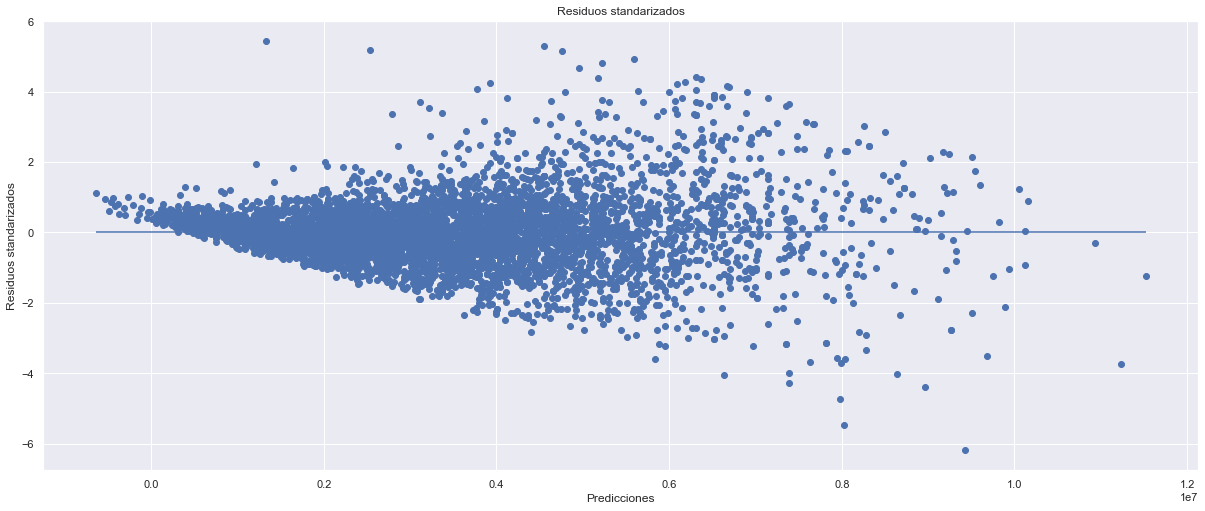

<Figure size 2160x2160 with 0 Axes>

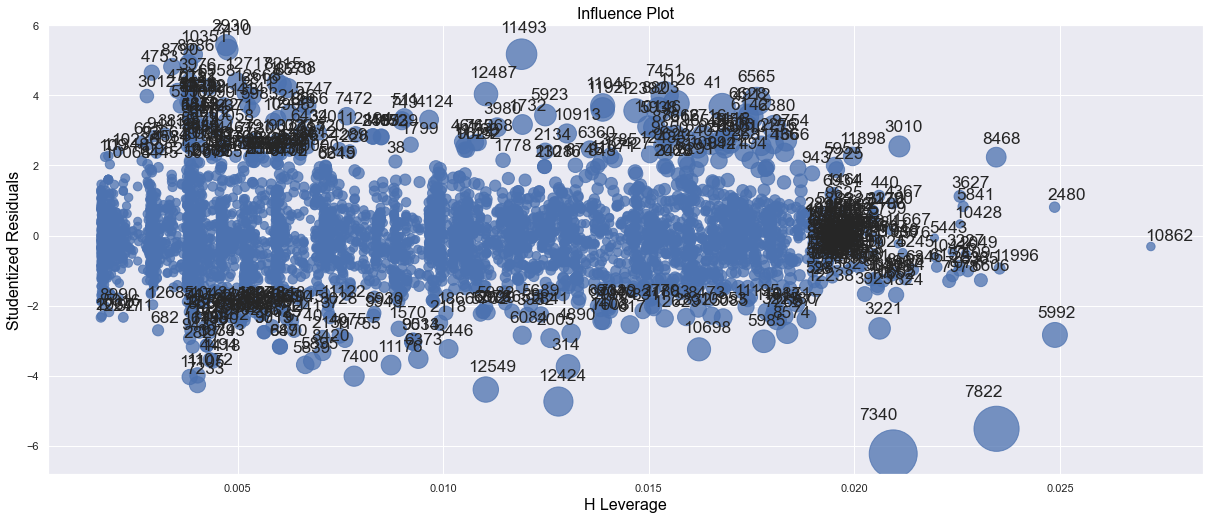

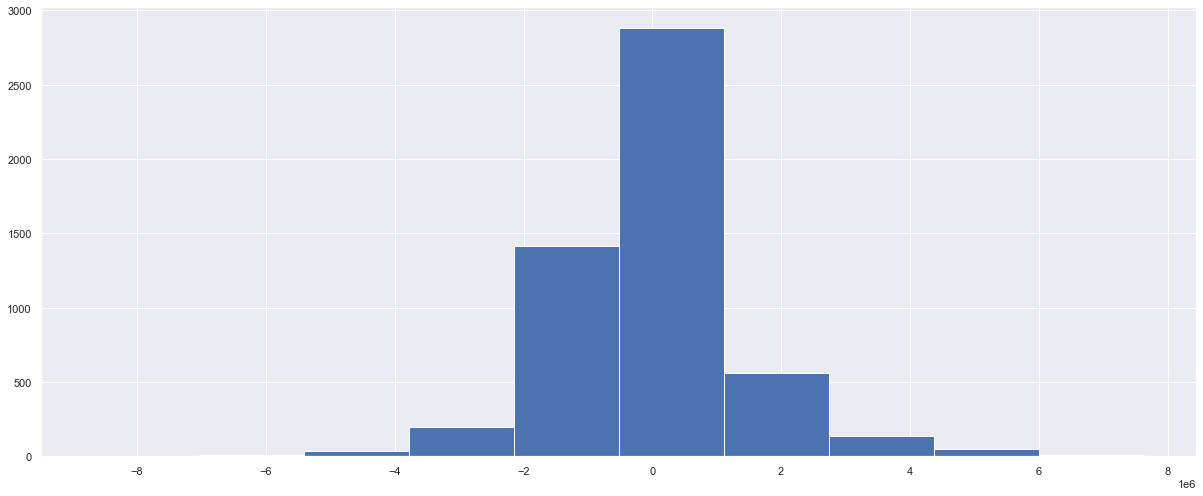

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1280bd220>,
 'r2': 0.6285370587111032,
 'rmse': 1404583.1358163392,
 'adjusted': 0.6250661044542085,
 'standarized_residuals': 1       -0.544489
 2        0.443196
 6       -0.560310
 8       -0.405389
 9        0.329646
            ...   
 12720    0.463434
 12721    0.024648
 12722   -1.555703
 12723   -0.365452
 12728   -0.293341
 Name: precio, Length: 5294, dtype: float64,
 'fitted': array([1964779.9907627 ,  202493.77538939, 2087002.51527899, ...,
        3825113.85731842, 4513308.05074424, 4162021.44584569])}

In [146]:
run_analysis(['normalizado_metrostotales', 
              'tipodepropiedad_encoded',
              'metrostotales_por_tipo',
              'amenities_deluxe'] + zonas, con_zonas)

# Por que no agrego zonas + ciudades???

VIF for normalizado_metrostotales 2.717128068911735
VIF for tipodepropiedad_encoded 2.436595260112148
VIF for metrostotales_por_tipo 2.6662741632509968
VIF for amenities_deluxe 1.467613372874819
VIF for 23191.0 1.1282351995277582
VIF for 23263.0 1.0517790683347168
VIF for 23343.0 1.0375169415490082
VIF for 23365.0 1.0271731182561752
VIF for 23533.0 1.0336375836612324
VIF for 23540.0 1.0361857264896441
VIF for 23555.0 1.01100846290102
VIF for 23560.0 1.0214941890138431
VIF for 23567.0 1.0235109336098704
VIF for 23569.0 1.0168865346294376
VIF for 23575.0 1.0037916709994568
VIF for 23576.0 1.0162253610636947
VIF for 23592.0 1.11812936224069
VIF for 23598.0 1.0478219597136857
VIF for 23698.0 1.0227970120353758
VIF for 23734.0 1.0408417730114452
VIF for 23771.0 1.1343269258490185
VIF for 23815.0 1.0254809985426292
VIF for 23816.0 1.0011564575591654
VIF for 23827.0 1.0293073131877348
VIF for 23832.0 1.0369688724118478
VIF for 23837.0 1.0098370896306774
VIF for 23842.0 1.014468299455409
VIF f

/usr/local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


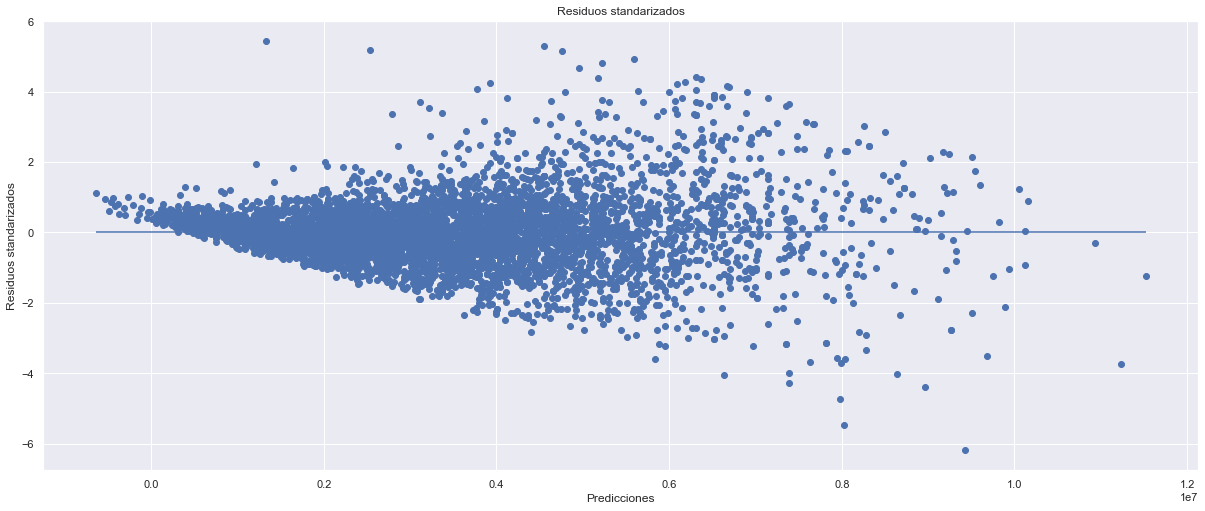

<Figure size 2160x2160 with 0 Axes>

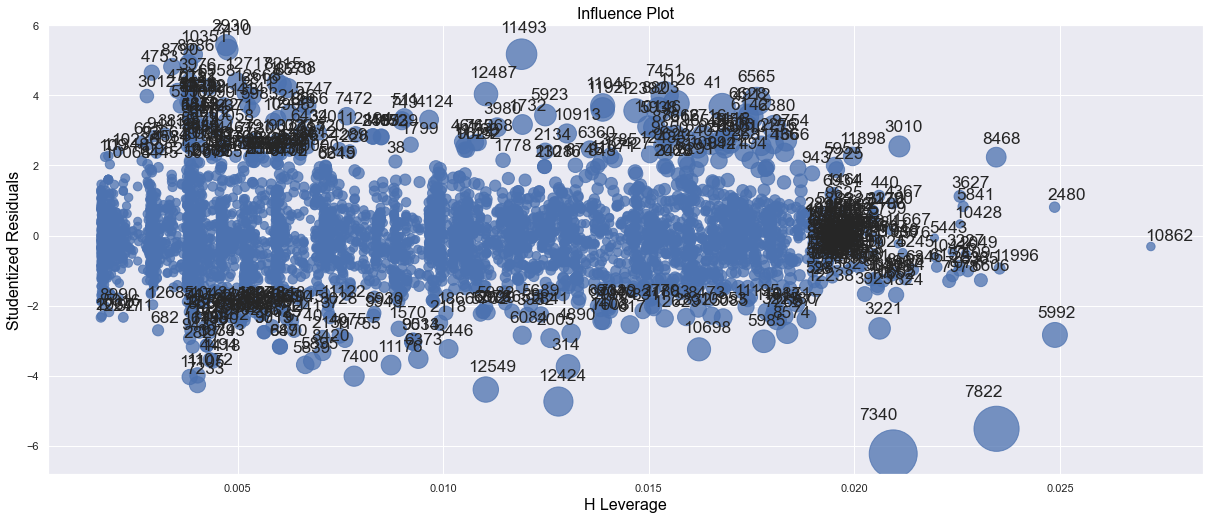

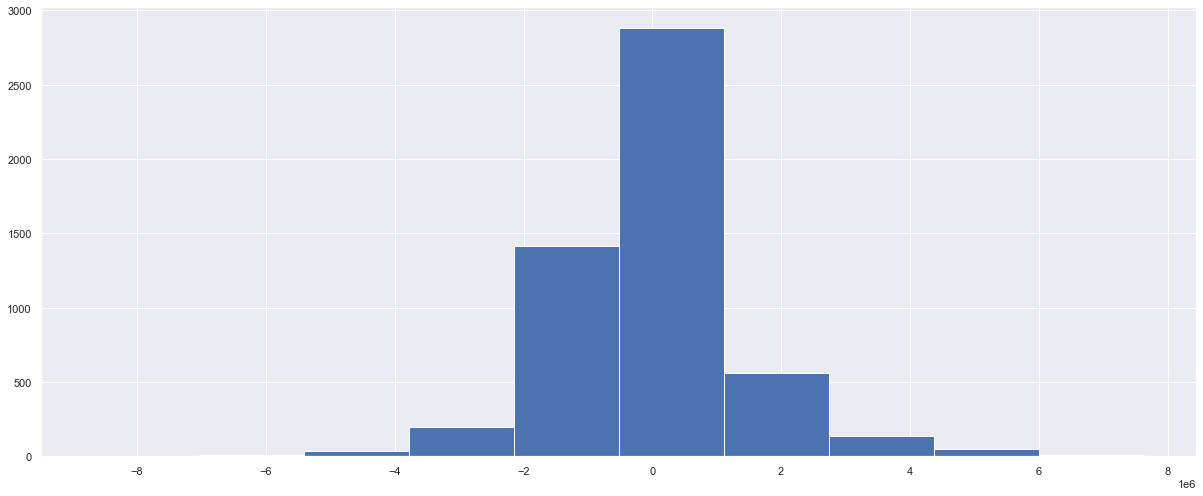

In [147]:
resultado = run_analysis(['normalizado_metrostotales', 
              'tipodepropiedad_encoded',
              'metrostotales_por_tipo',
              'amenities_deluxe'] + zonas, con_zonas)

In [148]:
resultado.keys()

dict_keys(['model', 'r2', 'rmse', 'adjusted', 'standarized_residuals', 'fitted'])

In [157]:
len(con_zonas), len()

(5294, 2)

In [165]:
con_zonas['cook']=resultado['model'].get_influence().cooks_distance[0]